This script will show you how to read frames from a video, resize it and sample sub-images

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
from google.colab.patches import cv2_imshow
from IPython.display import clear_output, Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import tensorflow as tf
from collections import Counter 
import pandas as pd

In [3]:
#We change the classes from numbers to labels
def get_class(label):
    """Gets the class name for a given label.
    
    Arguments:
        label (int): The integer target label.
        
    Returns:
        The name of the class that corresponds to the given label.
    """
    return ['chip', 'pellet', 'fine','lump','mixed'][label]

In [4]:
num_classes = 5
input_shape = (100,100,3)

In [5]:
# This is simply an alias for convenience
layers = tf.keras.layers

'''INPUT:
      num_classes = len(np.unique(target)) (number of classes in the target)
      input_shape = x_train.shape[1:] (the shape of our dataset excluding the first dimension corresponding to the number of images)
  OUTPUT: 
      the model
  CALL: 
      model = build_pretrained_vgg_model(num_classes, input_shape) 
      model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.005), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) '''

def build_pretrained_vgg_model(num_classes, input_shape): 
  """Constructs a CNN with a VGG16's convolutional base and two fully-connected hidden layers on top. The convolutional base is frozen (the weights can't be updated) and has weights from training on the ImageNet dataset.
  Returns:
    The model.
  """
  # This loads the VGG16 model from TensorFlow with ImageNet weights
  vgg_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
 
  # First we flatten out the features from the VGG16 model
  net = layers.Flatten()(vgg_model.output)
 
  # We create a new fully-connected layer that takes the flattened features as its input
  net = layers.Dense(512, activation=tf.nn.relu)(net)
  # And we add one more hidden layer
  net = layers.Dense(512, activation=tf.nn.relu)(net)
 
  # Then we add a final layer which is connected to the previous layer and
  # groups our images into one of the five classes
  output = layers.Dense(num_classes, activation=tf.nn.softmax)(net)
 
  # Finally, we create a new model whose input is that of the VGG16 model and whose output
  # is the final new layer we just created
  model = tf.keras.Model(inputs=vgg_model.input, outputs=output)
 
  # We loop through all layers except the last four and specify that we do not want 
  # their weights to be updated during training. The weights of the convolutional
  # layers have already been trained for general-purpose feature extraction, and we only
  # want to update the fully-connected layers that we just added.
  for layer in model.layers[:-4]:
      layer.trainable = False
 
  return model



In [6]:
def sample_image(img, x, y, win_size, cnn_size):
  h, w, = img.shape

  delta = int(win_size/2)

  x0 = x - delta 
  x1 = x + delta
  y0 = y - delta
  y1 = y + delta

  if y0 < 0:
      y0 = int(0)
      y1 = int(win_size * 2)
  
  if y1 > h:
      y0 = int(h - win_size * 2)
      y1 = int(h)
  
  if x0 < 0:
      x0 = int(0)
      x1 = int(win_size * 2)
  
  if x1 > w:
      x0 = int(w - win_size * 2)
      x1 = int(w)

  img_sample = img[y0:y1, x0:x1]

  # convert to CNN format
  img_cnn = cv2.resize(img_sample, (cnn_size,cnn_size))
  img_cnn = (np.ndarray.astype(img_cnn, np.float32) - 127.5) / 127.5
  img_cnn = np.reshape(img_cnn, (1, cnn_size, cnn_size, 1))
  img_cnn = np.repeat(img_cnn, 3, axis=3)

  return img_cnn, [x0,x1,y0,y1]

In [7]:
# This is the directory where model weights will be saved. 
CHECKPOINT_DIR = '/content/drive/My Drive/Colab Notebooks/Module 2/'

#We choose the epoch when the validation loss is lowest and accuracy highest
EARLY_STOPPING_EPOCH = 20

assert EARLY_STOPPING_EPOCH > 0, 'Set an early stopping point!'

# Path the the checkpoint we want to load
es_ckpt_path = os.path.join(CHECKPOINT_DIR, 'Half-size_weights.epoch.{:02d}'.format(EARLY_STOPPING_EPOCH))

#We define our model with the above function
model = build_pretrained_vgg_model(num_classes, input_shape)

# Then we load the weights from the desired checkpoint into the model
model.load_weights(es_ckpt_path);

#We can then use this model to predict. In this case, this step of reloading was not necessary since we used want to keep our last model (and set of parameters) anyway.

58892288/58889256 [==============================] - 2s 0us/step


## Bin 3

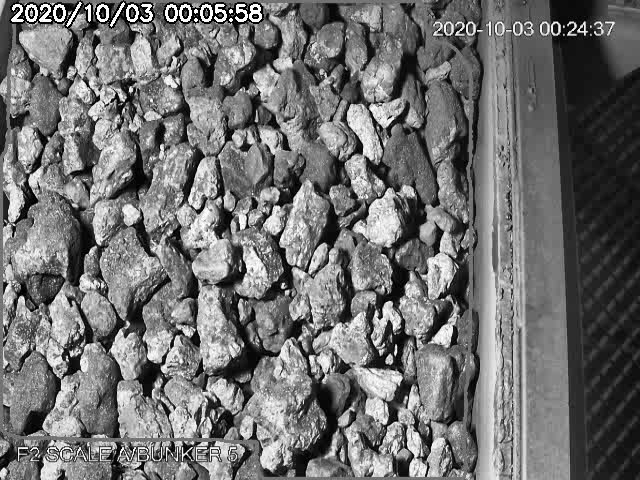

lump
7.152775610999999


In [ ]:
vid_path = "/content/drive/Shared drives/DSI Shared Folder/Module 2/Twist Data/bin_3.mp4"

cap = cv2.VideoCapture(vid_path)

N_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

sample_window_size = 100
cnn_img_size = 100
all_predictions_graph = np.zeros((0,9))
predicted_probabilities_graph = np.zeros((0,5))
frames = np.zeros((0))
not_frames = np.zeros((0))

tic = time.process_time()

#First frame
has_img, img = cap.read() # Blue, Green, Red Numpy Array uint8
frames = np.append(frames, 0)

if has_img:
  # Images in your training set were monochrome
  img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  unique, counts = np.unique(img_mono, return_counts=True)
  dict_unique = dict(zip(unique, counts))
  if 0 in unique and (counts[0]/np.sum(counts) < 0.9):

    # Grab a sample from the image. X=0, Y=0 is the top left corner. X and Y indicates the center of the sample.
    #x = 300
    #y = 200
    all_predictions = np.zeros((0))
    predicted_probabilities = np.zeros((5))

    for x in [200,300,400]:
      for y in [100,250,400]:
        sample, rect = sample_image(img_mono, int(x), int(y), sample_window_size, cnn_img_size)

        # TODO: CLASSIFER CODE HERE
        # The model gives us a matrix with each example's softmax probabilities for each class
        #print(predicted_probabilities)
        predicted_probabilities_new = model.predict(sample)
        #print("Sum predictions: ", np.sum(predicted_probabilities_new))
        predicted_probabilities = np.sum([predicted_probabilities, predicted_probabilities_new], axis=0)
        #print(predicted_probabilities)

        # We reduce that to a single predicted class for each example by taking the
        # class with the largest probability
        #prediction = np.argmax(predicted_probabilities, axis=1)
        
        #all_predictions = np.append(all_predictions, prediction)

    predicted_probabilities = predicted_probabilities/9
    #print(predicted_probabilities)
    #print("Sum probabilities for frame: ",np.sum(predicted_probabilities[0]))
    predicted_probabilities_graph = np.concatenate((predicted_probabilities_graph, predicted_probabilities),axis=0)
    #print(predicted_probabilities_graph)
    #occurence_count = Counter(all_predictions) 
    chip_per = predicted_probabilities[0][0]*100
    pell_per = predicted_probabilities[0][1]*100
    fine_per = predicted_probabilities[0][2]*100
    lump_per = predicted_probabilities[0][3]*100
    mix_per = predicted_probabilities[0][4]*100

    #print("Chip before: ", chip_per)
    #print("Pellets before: ", pell_per)
    #print("Fines before: ", fine_per)
    #print("Lump before: ", lump_per)
    #print("Mixed before: ", mix_per)
    #most_class_i = occurence_count.most_common(1)[0][0] 

    #clear_output(wait=True)      
    cv2_imshow(img_mono) 
    prediction = np.argmax(predicted_probabilities, axis=1)
    #print(prediction)
    #print(prediction[0])
    img_class = get_class(prediction[0])
    print(img_class)
  

#for frame_num in range(N_frames):
for frame_num in range(1, 100):
  frames = np.append(frames, frame_num)
  has_img, img = cap.read() # Blue, Green, Red Numpy Array uint8

  if has_img: # and frame_num in range(450,550):
    # Images in your trainging set were monochrome
    img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    unique, counts = np.unique(img_mono, return_counts=True)
    dict_unique = dict(zip(unique, counts))
    if 0 in unique and (counts[0]/np.sum(counts) < 0.9):

      # Grab a sample from the image. X=0, Y=0 is the top left corner. X and Y indicates the center of the sample.
      #x = 300
      #y = 200
      all_predictions = np.zeros((0))
      predicted_probabilities = np.zeros((5))

      for x in [200,300,400]:
        for y in [100,250,400]:
          sample, rect = sample_image(img_mono, int(x), int(y), sample_window_size, cnn_img_size)

          # TODO: CLASSIFER CODE HERE
          # The model gives us a matrix with each example's softmax probabilities for each class
          predicted_probabilities_new = model.predict(sample)

          #print("Sum predictions: ", np.sum(predicted_probabilities_new))

          predicted_probabilities = np.sum([predicted_probabilities, predicted_probabilities_new], axis=0)

          # We reduce that to a single predicted class for each example by taking the
          # class with the largest probability
          #prediction = np.argmax(predicted_probabilities, axis=1)
        
          #all_predictions = np.append(all_predictions, prediction)

      #occurence_count = Counter(all_predictions) 
      #most_class = occurence_count.most_common(1)[0][0] 

      # TODO: DECIDE IF NOFITICATION FRAME SHOUD BE SAVED

      predicted_probabilities = predicted_probabilities/9

      #print("Sum probabilities for frame: ",np.sum(predicted_probabilities[0]))

      chip_per_new = predicted_probabilities[0][0]*100
      pell_per_new = predicted_probabilities[0][1]*100
      fine_per_new = predicted_probabilities[0][2]*100
      lump_per_new = predicted_probabilities[0][3]*100
      mix_per_new = predicted_probabilities[0][4]*100

      if  ( ((abs(chip_per_new - chip_per) > 20 or abs(lump_per_new - lump_per) > 20) and (img_class != 'lump' and img_class != 'chip')) or abs(pell_per_new - pell_per) > 20 or abs(fine_per_new - fine_per) > 20 or (mix_per_new - mix_per) > 20):

        not_frames = np.append(not_frames, frame_num)
        #most_class_i = most_class
        #plt.imshow(sample[0], cmap='gray')

        #clear_output(wait=True)      
        prediction = np.argmax(predicted_probabilities, axis=1)
        cv2_imshow(img_mono) 
        img_class = get_class(prediction[0])

        print("Frame number: ", frame_num, " most common class: ", img_class)
        print("Chip before: ", chip_per, " and after: ", chip_per_new)
        print("Pellets before: ", pell_per, " and after: ", pell_per_new)
        print("Fines before: ", fine_per, " and after: ", fine_per_new)
        print("Lump before: ", lump_per, " and after: ", lump_per_new)
        print("Mixed before: ", mix_per, " and after: ", mix_per_new)



      # TODO: BUILD ARRAY FOR MATERIAL COMPOSITION GRAPH

      chip_per = chip_per_new
      pell_per = pell_per_new
      fine_per = fine_per_new
      lump_per = lump_per_new
      mix_per = mix_per_new
      predicted_probabilities_graph = np.concatenate((predicted_probabilities_graph, predicted_probabilities),axis=0)

      # COLAB
      # - - - - - - - - - - - - 
      #clear_output(wait=True)
      #cv2_imshow(sample[0]) 
      #plt.imshow(sample[0], cmap='gray')
      #print(img_class)
      #cv2.waitKey(1000) & 0xff
      # - - - - - - - - - - - - 

      # Local
      # - - - - - - - - - - - - 
      #cv2.imshow(img_mono)
      #cv2.waitKey(1000)
      # - - - - - - - - - - - -  

dt = time.process_time() - tic

print(dt/100)
#print(dt/N_frames) # Samples per frame should be below 150 ms


In [ ]:
df = pd.DataFrame({'frame': [], 'chip': [], 'pellet':[], 'fine':[],'lump':[],'mixed':[]})
for i in frames.astype(int):
  row_df = pd.DataFrame({'frame': [i], 'chip': [predicted_probabilities_graph[i][0]*100], 'pellet':[predicted_probabilities_graph[i][1]*100], 'fine':[predicted_probabilities_graph[i][2]*100],'lump':[predicted_probabilities_graph[i][3]*100],'mixed':[predicted_probabilities_graph[i][4]*100]})
  df = pd.concat([df, row_df], ignore_index=True)

In [ ]:
df

frame       chip        pellet      fine       lump      mixed
0     0.0   6.936450  1.411512e-06  0.000299  74.624259  18.438991
1     1.0  13.338175  2.191171e-06  0.000154  64.913186  21.748484
2     2.0  14.025194  2.118324e-06  0.000074  61.116319  24.858409
3     3.0  16.124922  1.380628e-06  0.000107  60.194579  23.680391
4     4.0  16.730691  2.356928e-06  0.000044  58.959122  24.310140
..    ...        ...           ...       ...        ...        ...
95   95.0  14.100669  7.166568e-07  0.000070  80.223502   5.675757
96   96.0   0.053710  3.505265e-08  0.000114  83.727198  16.218976
97   97.0   0.028687  2.207836e-08  0.000242  83.161260  16.809812
98   98.0   0.169577  3.917497e-08  0.000067  85.246537  14.583819
99   99.0   0.363097  7.219936e-08  0.000100  84.009913  15.626890

[100 rows x 6 columns]

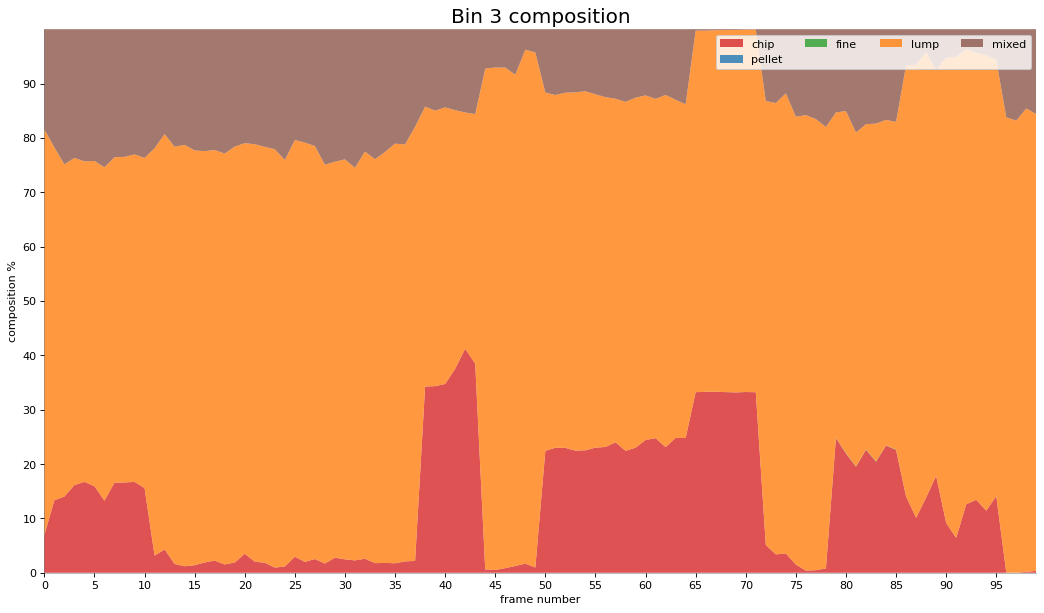

In [ ]:
# Decide Colors 
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 'tab:grey', 'tab:pink', 'tab:olive']      

# Draw Plot and Annotate
fig, ax = plt.subplots(1,1,figsize=(16, 9), dpi= 80)
columns = df.columns[1:]
labs = columns.values.tolist()

# Prepare data
x  = df['frame'].values.tolist()
y0 = df[columns[0]].values.tolist()
y1 = df[columns[1]].values.tolist()
y2 = df[columns[2]].values.tolist()
y3 = df[columns[3]].values.tolist()
y4 = df[columns[4]].values.tolist()
y = np.vstack([y0, y1, y2, y3, y4])

# Plot for each column
labs = columns.values.tolist()
ax = plt.gca()
ax.stackplot(x, y, labels=labs, colors=mycolors, alpha=0.8)

# Decorations
ax.set_title('Bin 3 composition', fontsize=18)
ax.set(ylim=[0, 100])
ax.legend(fontsize=10, ncol=4)
plt.xticks(x[::5], fontsize=10, horizontalalignment='center')
plt.yticks(np.arange(0, 100, 10), fontsize=10)
plt.xlim(x[0], x[-1])
plt.xlabel('frame number')
plt.ylabel('composition %')

for i in not_frames:
  plt.axvline(x=i)

# Lighten borders
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)

plt.show()

## Bin 3 interesting

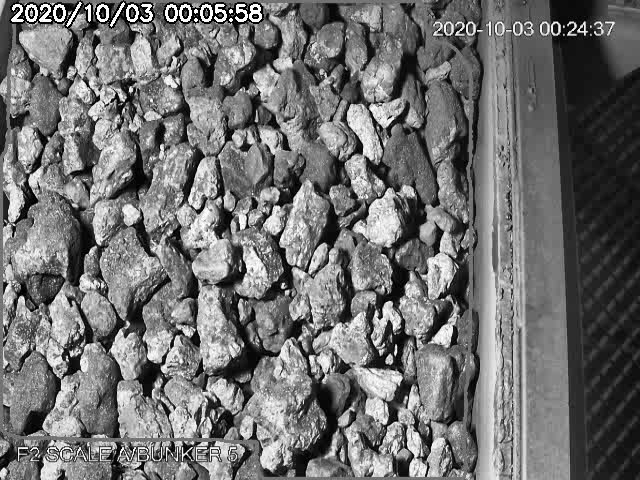

lump


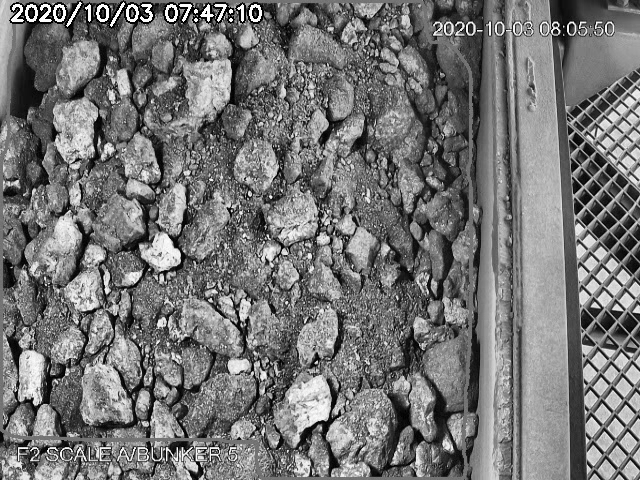

Frame number:  474  most common class:  mixed
Chip before:  19.52646020305998  and after:  11.062242536684783
Pellets before:  1.6497465678971812e-05  and after:  1.4300360668468355e-05
Fines before:  5.899649056691677e-05  and after:  1.2122071113048427
Lump before:  55.69737303449074  and after:  42.56470323776335
Mixed before:  24.77609151984426  and after:  45.160831562760805


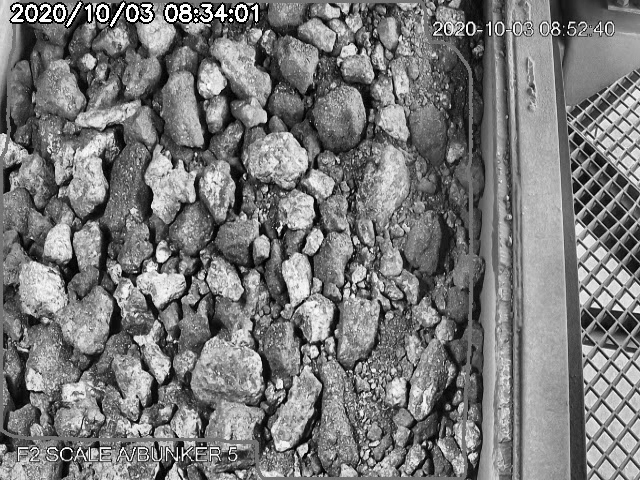

Frame number:  521  most common class:  change
Chip before:  25.06895275042022  and after:  11.664441060881042
Pellets before:  4.955051448164561e-05  and after:  2.228710317755353e-05
Fines before:  0.005184934359674869  and after:  0.0005920941350322075
Lump before:  15.087937917813102  and after:  39.494069126958586
Mixed before:  59.83787201758888  and after:  48.840872814050975


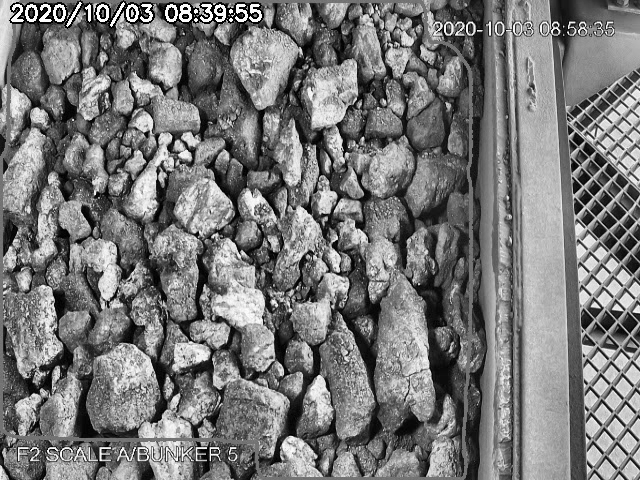

Frame number:  527  most common class:  lump
Chip before:  13.129589999851355  and after:  22.20622220301614
Pellets before:  1.37783942121073e-05  and after:  5.421103111326653e-06
Fines before:  0.00031253723634683223  and after:  1.5771372982895412e-05
Lump before:  40.913653326964614  and after:  73.78073988889405
Mixed before:  45.95642902697566  and after:  4.0130163740501406


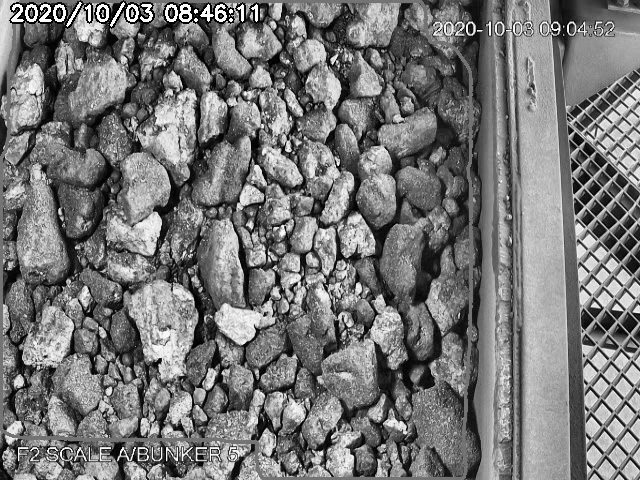

Frame number:  534  most common class:  chip
Chip before:  22.572895586449036  and after:  47.39710623681442
Pellets before:  5.926832248636174e-06  and after:  4.25616491257861e-05
Fines before:  2.7903552510563953e-05  and after:  4.129334034135586e-05
Lump before:  74.9812822468559  and after:  17.136911608542984
Mixed before:  2.4457857509585463  and after:  35.46589749565909
2.92961595249


In [8]:
vid_path = "/content/drive/Shared drives/DSI Shared Folder/Module 2/Twist Data/bin_3.mp4"

cap = cv2.VideoCapture(vid_path)

N_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

sample_window_size = 100
cnn_img_size = 100
all_predictions_graph = np.zeros((0,9))
predicted_probabilities_graph = np.zeros((0,5))
frames = np.zeros((0))
not_frames = np.zeros((0))

tic = time.process_time()

#First frame
has_img, img = cap.read() # Blue, Green, Red Numpy Array uint8
frames = np.append(frames, 0)

if has_img:
  # Images in your training set were monochrome
  img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  unique, counts = np.unique(img_mono, return_counts=True)
  dict_unique = dict(zip(unique, counts))
  if 0 in unique and (counts[0]/np.sum(counts) < 0.9):

    # Grab a sample from the image. X=0, Y=0 is the top left corner. X and Y indicates the center of the sample.
    #x = 300
    #y = 200
    all_predictions = np.zeros((0))
    predicted_probabilities = np.zeros((5))

    for x in [200,300,400]:
      for y in [100,250,400]:
        sample, rect = sample_image(img_mono, int(x), int(y), sample_window_size, cnn_img_size)

        # TODO: CLASSIFER CODE HERE
        # The model gives us a matrix with each example's softmax probabilities for each class
        #print(predicted_probabilities)
        predicted_probabilities_new = model.predict(sample)
        #print("Sum predictions: ", np.sum(predicted_probabilities_new))
        predicted_probabilities = np.sum([predicted_probabilities, predicted_probabilities_new], axis=0)
        #print(predicted_probabilities)

        # We reduce that to a single predicted class for each example by taking the
        # class with the largest probability
        #prediction = np.argmax(predicted_probabilities, axis=1)
        
        #all_predictions = np.append(all_predictions, prediction)

    predicted_probabilities = predicted_probabilities/9
    #print(predicted_probabilities)
    #print("Sum probabilities for frame: ",np.sum(predicted_probabilities[0]))
    predicted_probabilities_graph = np.concatenate((predicted_probabilities_graph, predicted_probabilities),axis=0)
    #print(predicted_probabilities_graph)
    #occurence_count = Counter(all_predictions) 
    chip_per = predicted_probabilities[0][0]*100
    pell_per = predicted_probabilities[0][1]*100
    fine_per = predicted_probabilities[0][2]*100
    lump_per = predicted_probabilities[0][3]*100
    mix_per = predicted_probabilities[0][4]*100

    #print("Chip before: ", chip_per)
    #print("Pellets before: ", pell_per)
    #print("Fines before: ", fine_per)
    #print("Lump before: ", lump_per)
    #print("Mixed before: ", mix_per)
    #most_class_i = occurence_count.most_common(1)[0][0] 

    #clear_output(wait=True)      
    cv2_imshow(img_mono) 
    prediction = np.argmax(predicted_probabilities, axis=1)
    #print(prediction)
    #print(prediction[0])
    img_class = get_class(prediction[0])
    print(img_class)
  

#for frame_num in range(N_frames):
for frame_num in range(1, N_frames):

  has_img, img = cap.read() # Blue, Green, Red Numpy Array uint8

  if has_img and frame_num in range(450,550):
    frames = np.append(frames, frame_num)
    # Images in your trainging set were monochrome
    img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    unique, counts = np.unique(img_mono, return_counts=True)
    dict_unique = dict(zip(unique, counts))
    if 0 in unique and (counts[0]/np.sum(counts) < 0.9):

      # Grab a sample from the image. X=0, Y=0 is the top left corner. X and Y indicates the center of the sample.
      #x = 300
      #y = 200
      all_predictions = np.zeros((0))
      predicted_probabilities = np.zeros((5))

      for x in [200,300,400]:
        for y in [100,250,400]:
          sample, rect = sample_image(img_mono, int(x), int(y), sample_window_size, cnn_img_size)

          # TODO: CLASSIFER CODE HERE
          # The model gives us a matrix with each example's softmax probabilities for each class
          predicted_probabilities_new = model.predict(sample)

          #print("Sum predictions: ", np.sum(predicted_probabilities_new))

          predicted_probabilities = np.sum([predicted_probabilities, predicted_probabilities_new], axis=0)

          # We reduce that to a single predicted class for each example by taking the
          # class with the largest probability
          #prediction = np.argmax(predicted_probabilities, axis=1)
        
          #all_predictions = np.append(all_predictions, prediction)

      #occurence_count = Counter(all_predictions) 
      #most_class = occurence_count.most_common(1)[0][0] 

      # TODO: DECIDE IF NOFITICATION FRAME SHOUD BE SAVED

      predicted_probabilities = predicted_probabilities/9

      #print("Sum probabilities for frame: ",np.sum(predicted_probabilities[0]))

      chip_per_new = predicted_probabilities[0][0]*100
      pell_per_new = predicted_probabilities[0][1]*100
      fine_per_new = predicted_probabilities[0][2]*100
      lump_per_new = predicted_probabilities[0][3]*100
      mix_per_new = predicted_probabilities[0][4]*100

      if  ( ((abs(chip_per_new - chip_per) > 20 or abs(lump_per_new - lump_per) > 20) and (img_class != 'lump' and img_class != 'chip')) or abs(pell_per_new - pell_per) > 20 or abs(fine_per_new - fine_per) > 20 or (mix_per_new - mix_per) > 20):

        not_frames = np.append(not_frames, frame_num)
        #most_class_i = most_class
        #plt.imshow(sample[0], cmap='gray')

        #clear_output(wait=True)      
        prediction = np.argmax(predicted_probabilities, axis=1)
        cv2_imshow(img_mono) 
        img_class_temp = img_class
        img_class = get_class(prediction[0])

        if img_class == img_class_temp:
          img_class = 'change'
        print("Frame number: ", frame_num, " most common class: ", img_class)
        print("Chip before: ", chip_per, " and after: ", chip_per_new)
        print("Pellets before: ", pell_per, " and after: ", pell_per_new)
        print("Fines before: ", fine_per, " and after: ", fine_per_new)
        print("Lump before: ", lump_per, " and after: ", lump_per_new)
        print("Mixed before: ", mix_per, " and after: ", mix_per_new)



      # TODO: BUILD ARRAY FOR MATERIAL COMPOSITION GRAPH

      chip_per = chip_per_new
      pell_per = pell_per_new
      fine_per = fine_per_new
      lump_per = lump_per_new
      mix_per = mix_per_new
      predicted_probabilities_graph = np.concatenate((predicted_probabilities_graph, predicted_probabilities),axis=0)

      # COLAB
      # - - - - - - - - - - - - 
      #clear_output(wait=True)
      #cv2_imshow(sample[0]) 
      #plt.imshow(sample[0], cmap='gray')
      #print(img_class)
      #cv2.waitKey(1000) & 0xff
      # - - - - - - - - - - - - 

      # Local
      # - - - - - - - - - - - - 
      #cv2.imshow(img_mono)
      #cv2.waitKey(1000)
      # - - - - - - - - - - - -  

dt = time.process_time() - tic

print(dt/100)
#print(dt/N_frames) # Samples per frame should be below 150 ms


In [9]:
df = pd.DataFrame({'frame': [], 'chip': [], 'pellet':[], 'fine':[],'lump':[],'mixed':[]})
for i in range(1,100):
  row_df = pd.DataFrame({'frame': [frames[i]], 'chip': [predicted_probabilities_graph[i][0]*100], 'pellet':[predicted_probabilities_graph[i][1]*100], 'fine':[predicted_probabilities_graph[i][2]*100],'lump':[predicted_probabilities_graph[i][3]*100],'mixed':[predicted_probabilities_graph[i][4]*100]})
  df = pd.concat([df, row_df], ignore_index=True)

In [10]:
df

frame       chip    pellet      fine       lump      mixed
0   450.0  10.463738  0.000059  0.000006  71.975714  17.560488
1   451.0  10.303675  0.000059  0.000009  70.776344  18.919914
2   452.0  10.330105  0.000072  0.000007  68.617880  21.051936
3   453.0   9.794872  0.000072  0.000007  68.747596  21.457457
4   454.0  10.285376  0.000064  0.000005  72.427737  17.286820
..    ...        ...       ...       ...        ...        ...
94  544.0   0.053566  0.000001  0.001281  57.711932  42.233222
95  545.0   0.025504  0.000002  0.001047  58.769740  41.203708
96  546.0  36.114119  0.000009  0.000055  23.796066  40.089751
97  547.0  34.348023  0.000008  0.000041  27.596273  38.055654
98  548.0  35.460957  0.000010  0.000059  27.618391  36.920585

[99 rows x 6 columns]

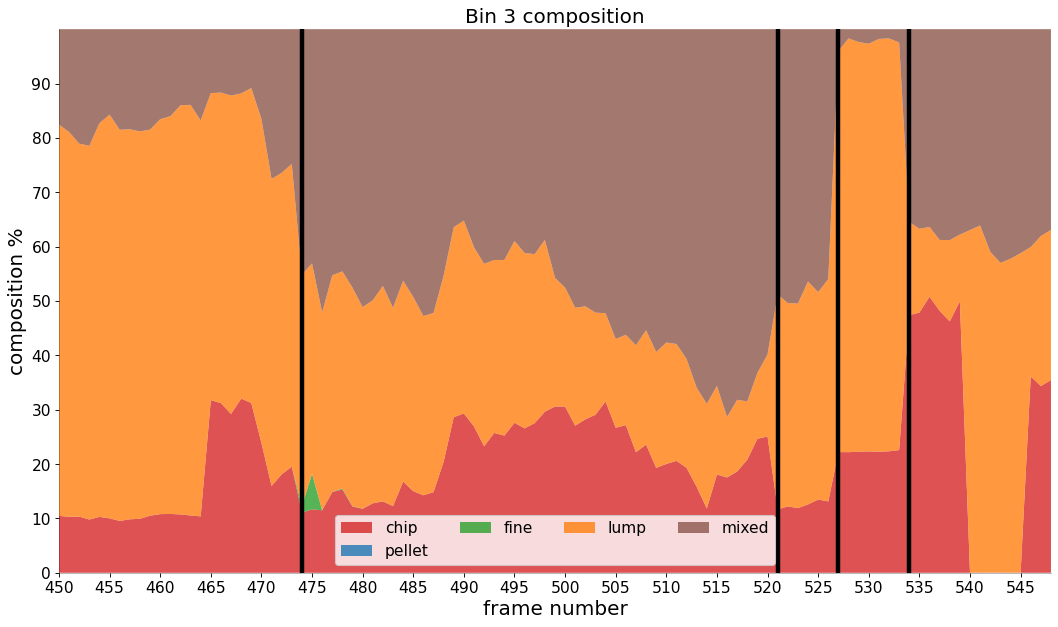

In [11]:
# Decide Colors 
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 'tab:grey', 'tab:pink', 'tab:olive']      

# Draw Plot and Annotate
fig, ax = plt.subplots(1,1,figsize=(16, 9), dpi= 80)
columns = df.columns[1:]
labs = columns.values.tolist()

# Prepare data
x  = df['frame'].values.tolist()
y0 = df[columns[0]].values.tolist()
y1 = df[columns[1]].values.tolist()
y2 = df[columns[2]].values.tolist()
y3 = df[columns[3]].values.tolist()
y4 = df[columns[4]].values.tolist()
y = np.vstack([y0, y1, y2, y3, y4])

# Plot for each column
labs = columns.values.tolist()
ax = plt.gca()
ax.stackplot(x, y, labels=labs, colors=mycolors, alpha=0.8)

# Decorations
ax.set_title('Bin 3 composition', fontsize=18)
ax.set(ylim=[0, 100])
ax.legend(fontsize=14, ncol=4)
plt.xticks(x[::5], fontsize=14, horizontalalignment='center')
plt.yticks(np.arange(0, 100, 10), fontsize=14)
plt.xlim(x[0], x[-1])
plt.xlabel('frame number', fontsize=18)
plt.ylabel('composition %', fontsize=18)

for i in not_frames:
  plt.axvline(x=i, linewidth=4, color='black')

# Lighten borders
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)

plt.show()

## Bin 1

In [ ]:
vid_path = "/content/drive/Shared drives/DSI Shared Folder/Module 2/Twist Data/bin_1.mp4"

cap = cv2.VideoCapture(vid_path)

N_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
has_img, img = cap.read()
img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

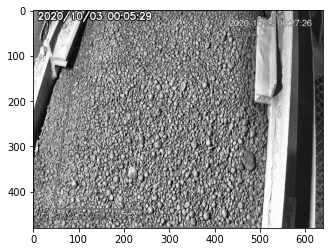

In [ ]:
plt.imshow(img_mono, cmap='gray')

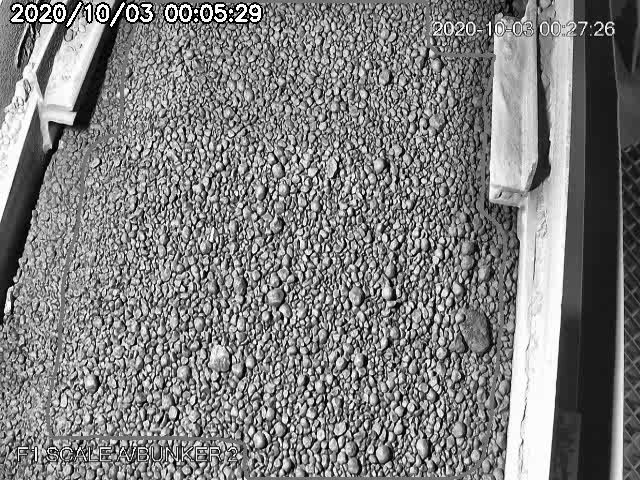

pellet


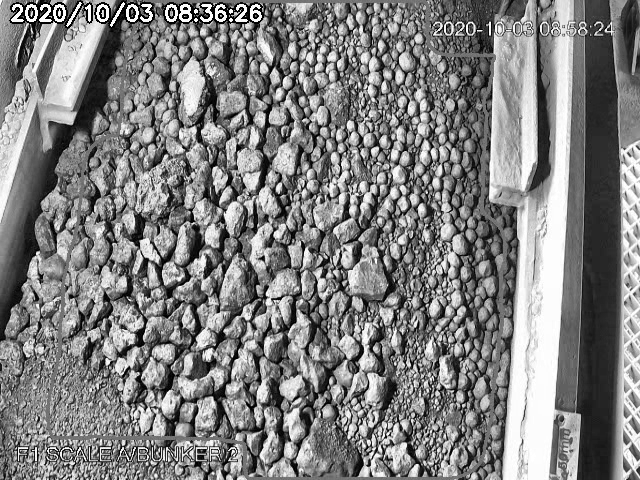

Frame number:  524  most common class:  chip
Chip before:  0.0106087665497196  and after:  74.62292721944553
Pellets before:  72.26165890590184  and after:  22.221933817738222
Fines before:  27.57536646284835  and after:  4.02097841629773e-08
Lump before:  0.009920356590637563  and after:  1.2003021444098423e-05
Mixed before:  0.1424464057991928  and after:  3.1551270155611


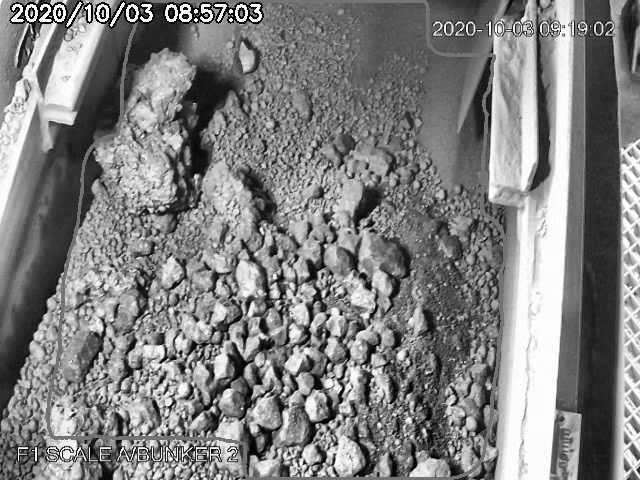

Frame number:  546  most common class:  mixed
Chip before:  71.77275396022029  and after:  20.74510858895681
Pellets before:  22.22551380215783  and after:  0.00013751473539047598
Fines before:  5.330529507884677e-08  and after:  24.13772539840705
Lump before:  1.30577233878492e-05  and after:  7.966793111989848
Mixed before:  6.001718124537724  and after:  47.15023876034239


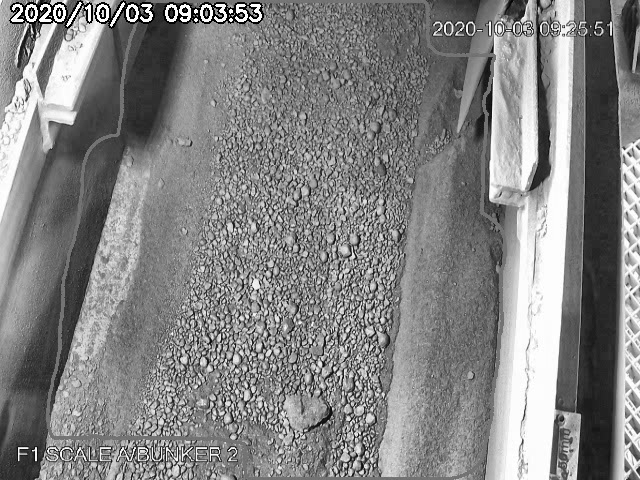

Frame number:  552  most common class:  fine
Chip before:  23.76021949860204  and after:  0.00011445673553247487
Pellets before:  0.000167854928822827  and after:  0.029911582696820174
Fines before:  29.665400807974518  and after:  57.530769774085556
Lump before:  0.43096658044960373  and after:  0.1070187201485674
Mixed before:  46.143244338165665  and after:  42.33218539870652


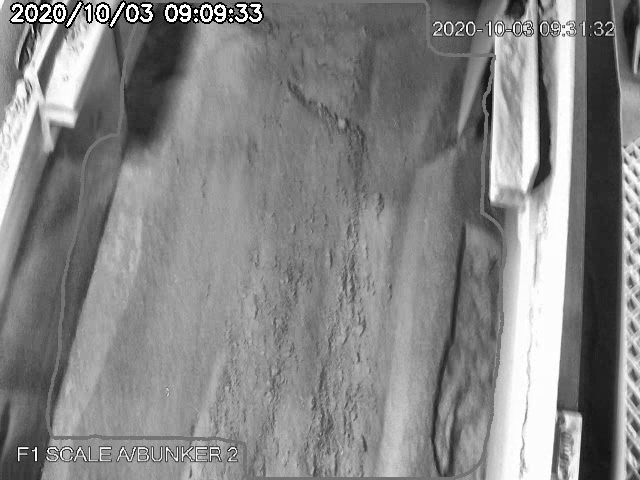

Frame number:  559  most common class:  change
Chip before:  0.0005892551378986848  and after:  6.617217937878242e-07
Pellets before:  0.007586953291611249  and after:  6.056714442635878e-06
Fines before:  61.0544136243536  and after:  99.86350867483351
Lump before:  0.07163884785212657  and after:  0.1315365042311593
Mixed before:  38.86577292780373  and after:  0.004949202620233942


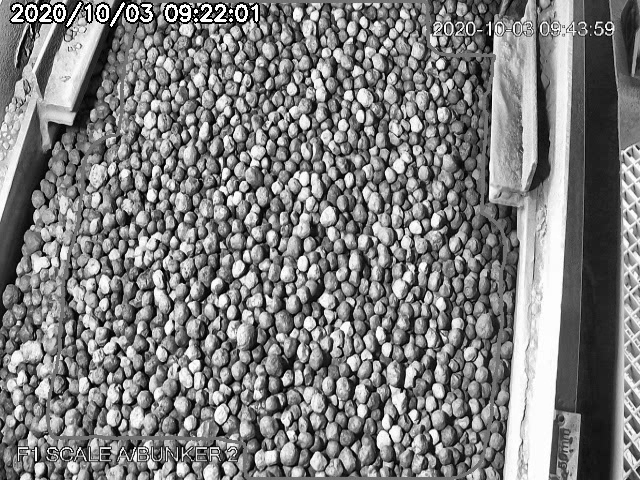

Frame number:  571  most common class:  pellet
Chip before:  3.332166857736142e-08  and after:  8.070617933658496e-09
Pellets before:  7.229850167618974e-07  and after:  100.0
Fines before:  99.25822549396091  and after:  3.3660764842346376e-12
Lump before:  0.24064427017896783  and after:  2.200315556525437e-12
Mixed before:  0.5011315354014556  and after:  6.024133069118531e-07
3.01748685695


In [12]:
vid_path = "/content/drive/Shared drives/DSI Shared Folder/Module 2/Twist Data/bin_1.mp4"

cap = cv2.VideoCapture(vid_path)

N_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

sample_window_size = 100
cnn_img_size = 100
all_predictions_graph = np.zeros((0,9))
predicted_probabilities_graph = np.zeros((0,5))
frames = np.zeros((0))
not_frames = np.zeros((0))

tic = time.process_time()

#First frame
has_img, img = cap.read() # Blue, Green, Red Numpy Array uint8
frames = np.append(frames, 0)

if has_img:
  # Images in your training set were monochrome
  img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  unique, counts = np.unique(img_mono, return_counts=True)
  dict_unique = dict(zip(unique, counts))
  if 0 in unique and (counts[0]/np.sum(counts) < 0.9):

    # Grab a sample from the image. X=0, Y=0 is the top left corner. X and Y indicates the center of the sample.
    #x = 300
    #y = 200
    all_predictions = np.zeros((0))
    predicted_probabilities = np.zeros((5))

    for x in [200,300,400]:
      for y in [100,250,400]:
        sample, rect = sample_image(img_mono, int(x), int(y), sample_window_size, cnn_img_size)

        # TODO: CLASSIFER CODE HERE
        # The model gives us a matrix with each example's softmax probabilities for each class
        #print(predicted_probabilities)
        predicted_probabilities_new = model.predict(sample)
        #print("Sum predictions: ", np.sum(predicted_probabilities_new))
        predicted_probabilities = np.sum([predicted_probabilities, predicted_probabilities_new], axis=0)
        #print(predicted_probabilities)

        # We reduce that to a single predicted class for each example by taking the
        # class with the largest probability
        #prediction = np.argmax(predicted_probabilities, axis=1)
        
        #all_predictions = np.append(all_predictions, prediction)

    predicted_probabilities = predicted_probabilities/9
    #print(predicted_probabilities)
    #print("Sum probabilities for frame: ",np.sum(predicted_probabilities[0]))
    predicted_probabilities_graph = np.concatenate((predicted_probabilities_graph, predicted_probabilities),axis=0)
    #print(predicted_probabilities_graph)
    #occurence_count = Counter(all_predictions) 
    chip_per = predicted_probabilities[0][0]*100
    pell_per = predicted_probabilities[0][1]*100
    fine_per = predicted_probabilities[0][2]*100
    lump_per = predicted_probabilities[0][3]*100
    mix_per = predicted_probabilities[0][4]*100

    #print("Chip before: ", chip_per)
    #print("Pellets before: ", pell_per)
    #print("Fines before: ", fine_per)
    #print("Lump before: ", lump_per)
    #print("Mixed before: ", mix_per)
    #most_class_i = occurence_count.most_common(1)[0][0] 

    #clear_output(wait=True)      
    cv2_imshow(img_mono) 
    prediction = np.argmax(predicted_probabilities, axis=1)
    #print(prediction)
    #print(prediction[0])
    img_class = get_class(prediction[0])
    print(img_class)
  

#for frame_num in range(N_frames):
for frame_num in range(1, N_frames):

  has_img, img = cap.read() # Blue, Green, Red Numpy Array uint8

  if has_img and frame_num in range(500,600):
    frames = np.append(frames, frame_num)
    # Images in your trainging set were monochrome
    img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    unique, counts = np.unique(img_mono, return_counts=True)
    dict_unique = dict(zip(unique, counts))
    if 0 in unique and (counts[0]/np.sum(counts) < 0.9):

      # Grab a sample from the image. X=0, Y=0 is the top left corner. X and Y indicates the center of the sample.
      #x = 300
      #y = 200
      all_predictions = np.zeros((0))
      predicted_probabilities = np.zeros((5))

      for x in [200,300,400]:
        for y in [100,250,400]:
          sample, rect = sample_image(img_mono, int(x), int(y), sample_window_size, cnn_img_size)

          # TODO: CLASSIFER CODE HERE
          # The model gives us a matrix with each example's softmax probabilities for each class
          predicted_probabilities_new = model.predict(sample)

          #print("Sum predictions: ", np.sum(predicted_probabilities_new))

          predicted_probabilities = np.sum([predicted_probabilities, predicted_probabilities_new], axis=0)

          # We reduce that to a single predicted class for each example by taking the
          # class with the largest probability
          #prediction = np.argmax(predicted_probabilities, axis=1)
        
          #all_predictions = np.append(all_predictions, prediction)

      #occurence_count = Counter(all_predictions) 
      #most_class = occurence_count.most_common(1)[0][0] 

      # TODO: DECIDE IF NOFITICATION FRAME SHOUD BE SAVED

      predicted_probabilities = predicted_probabilities/9

      #print("Sum probabilities for frame: ",np.sum(predicted_probabilities[0]))

      chip_per_new = predicted_probabilities[0][0]*100
      pell_per_new = predicted_probabilities[0][1]*100
      fine_per_new = predicted_probabilities[0][2]*100
      lump_per_new = predicted_probabilities[0][3]*100
      mix_per_new = predicted_probabilities[0][4]*100

      if  ( ((abs(chip_per_new - chip_per) > 20 or abs(lump_per_new - lump_per) > 20) and (img_class != 'lump' and img_class != 'chip')) or abs(pell_per_new - pell_per) > 20 or abs(fine_per_new - fine_per) > 20 or (mix_per_new - mix_per) > 20):

        not_frames = np.append(not_frames, frame_num)
        #most_class_i = most_class
        #plt.imshow(sample[0], cmap='gray')

        #clear_output(wait=True)      
        prediction = np.argmax(predicted_probabilities, axis=1)
        cv2_imshow(img_mono) 
        img_class_temp = img_class
        img_class = get_class(prediction[0])

        if img_class == img_class_temp:
          img_class = 'change'
        print("Frame number: ", frame_num, " most common class: ", img_class)
        print("Chip before: ", chip_per, " and after: ", chip_per_new)
        print("Pellets before: ", pell_per, " and after: ", pell_per_new)
        print("Fines before: ", fine_per, " and after: ", fine_per_new)
        print("Lump before: ", lump_per, " and after: ", lump_per_new)
        print("Mixed before: ", mix_per, " and after: ", mix_per_new)



      # TODO: BUILD ARRAY FOR MATERIAL COMPOSITION GRAPH

      chip_per = chip_per_new
      pell_per = pell_per_new
      fine_per = fine_per_new
      lump_per = lump_per_new
      mix_per = mix_per_new
      predicted_probabilities_graph = np.concatenate((predicted_probabilities_graph, predicted_probabilities),axis=0)

      # COLAB
      # - - - - - - - - - - - - 
      #clear_output(wait=True)
      #cv2_imshow(sample[0]) 
      #plt.imshow(sample[0], cmap='gray')
      #print(img_class)
      #cv2.waitKey(1000) & 0xff
      # - - - - - - - - - - - - 

      # Local
      # - - - - - - - - - - - - 
      #cv2.imshow(img_mono)
      #cv2.waitKey(1000)
      # - - - - - - - - - - - -  

dt = time.process_time() - tic

print(dt/100)
#print(dt/N_frames) # Samples per frame should be below 150 ms


In [13]:
df = pd.DataFrame({'frame': [], 'chip': [], 'pellet':[], 'fine':[],'lump':[],'mixed':[]})
for i in range(1,100):
  row_df = pd.DataFrame({'frame': [frames[i]], 'chip': [predicted_probabilities_graph[i][0]*100], 'pellet':[predicted_probabilities_graph[i][1]*100], 'fine':[predicted_probabilities_graph[i][2]*100],'lump':[predicted_probabilities_graph[i][3]*100],'mixed':[predicted_probabilities_graph[i][4]*100]})
  df = pd.concat([df, row_df], ignore_index=True)

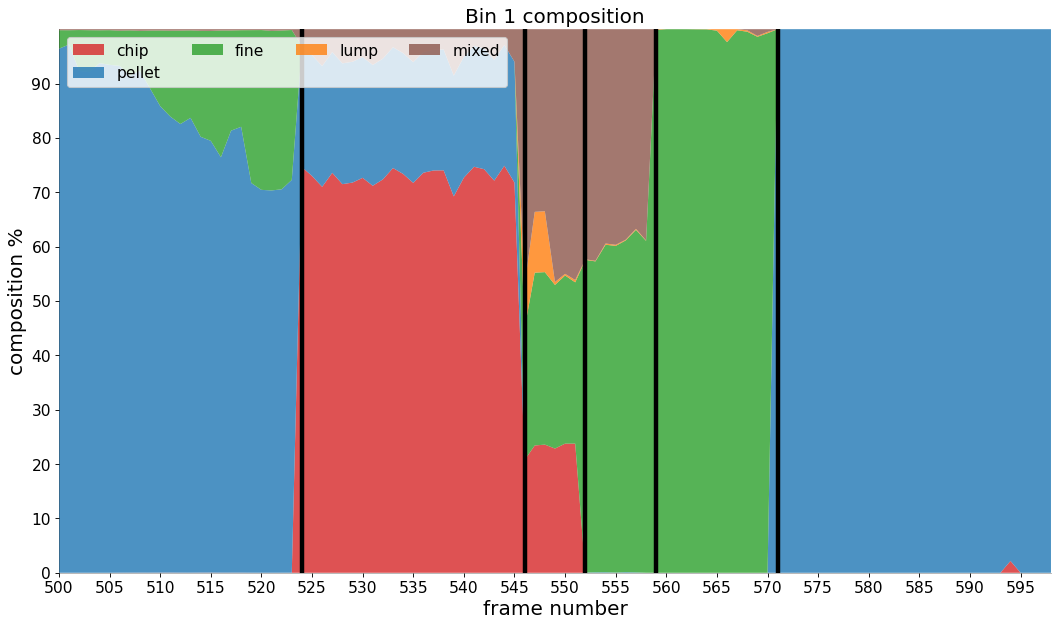

In [14]:
# Decide Colors 
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 'tab:grey', 'tab:pink', 'tab:olive']      

# Draw Plot and Annotate
fig, ax = plt.subplots(1,1,figsize=(16, 9), dpi= 80)
columns = df.columns[1:]
labs = columns.values.tolist()

# Prepare data
x  = df['frame'].values.tolist()
y0 = df[columns[0]].values.tolist()
y1 = df[columns[1]].values.tolist()
y2 = df[columns[2]].values.tolist()
y3 = df[columns[3]].values.tolist()
y4 = df[columns[4]].values.tolist()
y = np.vstack([y0, y1, y2, y3, y4])

# Plot for each column
labs = columns.values.tolist()
ax = plt.gca()
ax.stackplot(x, y, labels=labs, colors=mycolors, alpha=0.8)

# Decorations
ax.set_title('Bin 1 composition', fontsize=18)
ax.set(ylim=[0, 100])
ax.legend(fontsize=14, ncol=4)
plt.xticks(x[::5], fontsize=14, horizontalalignment='center')
plt.yticks(np.arange(0, 100, 10), fontsize=14)
plt.xlim(x[0], x[-1])
plt.xlabel('frame number', fontsize=18)
plt.ylabel('composition %', fontsize=18)

for i in not_frames:
  plt.axvline(x=i, linewidth=4, color='black')

# Lighten borders
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)

plt.show()

## Bin 2

In [ ]:
vid_path = "/content/drive/Shared drives/DSI Shared Folder/Module 2/Twist Data/bin_2.mp4"

cap = cv2.VideoCapture(vid_path)

N_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
has_img, img = cap.read()
has_img, img = cap.read()
has_img, img = cap.read()
if has_img:
  img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

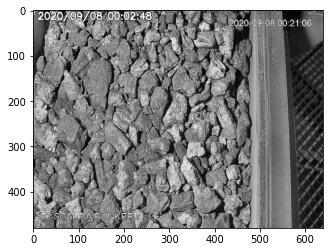

In [ ]:
plt.imshow(img_mono, cmap='gray')

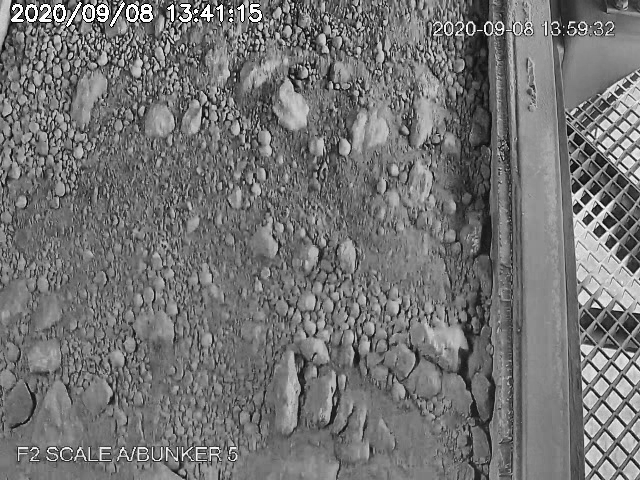

Frame number:  821  most common class:  change
Chip before:  2.6153640232519217e-05  and after:  4.541554920906946e-06
Pellets before:  7.430262552506515e-07  and after:  1.5285670724014437e-06
Fines before:  0.6154944668182906  and after:  33.13627660247627
Lump before:  0.0395094466722084  and after:  0.005677546586863653
Mixed before:  99.34496879577637  and after:  66.85803925983642


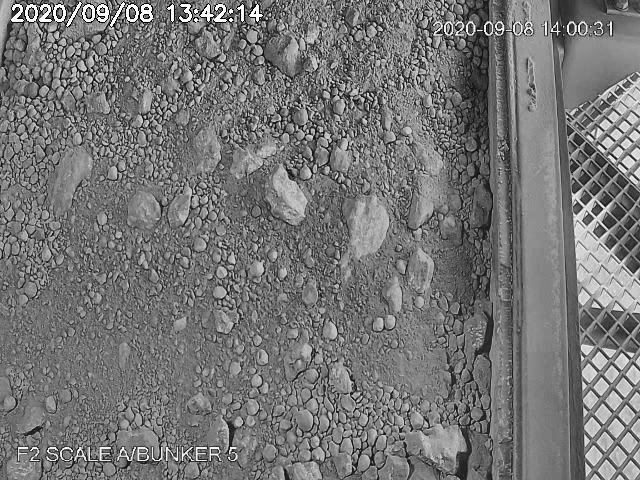

Frame number:  822  most common class:  mixed
Chip before:  4.541554920906946e-06  and after:  0.00034043976451849734
Pellets before:  1.5285670724014437e-06  and after:  4.5016506912226663e-07
Fines before:  33.13627660247627  and after:  0.08880666866382114
Lump before:  0.005677546586863653  and after:  0.00024852832913251847
Mixed before:  66.85803925983642  and after:  99.91060429149204
2.3921461632199996


In [31]:
vid_path = "/content/drive/Shared drives/DSI Shared Folder/Module 2/Twist Data/bin_2.mp4"

cap = cv2.VideoCapture(vid_path)

N_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

sample_window_size = 100
cnn_img_size = 100
all_predictions_graph = np.zeros((0,9))
predicted_probabilities_graph = np.zeros((0,5))
frames = np.zeros((0))
not_frames = np.zeros((0))

tic = time.process_time()

#First frame
has_img, img = cap.read() # Blue, Green, Red Numpy Array uint8

if has_img:
  # Images in your training set were monochrome
  img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  unique, counts = np.unique(img_mono, return_counts=True)
  dict_unique = dict(zip(unique, counts))
  if 0 in unique and (counts[0]/np.sum(counts) < 0.9):
    frames = np.append(frames, 0)
    # Grab a sample from the image. X=0, Y=0 is the top left corner. X and Y indicates the center of the sample.
    #x = 300
    #y = 200
    all_predictions = np.zeros((0))
    predicted_probabilities = np.zeros((5))

    for x in [200,300,400]:
      for y in [100,250,400]:
        sample, rect = sample_image(img_mono, int(x), int(y), sample_window_size, cnn_img_size)

        # TODO: CLASSIFER CODE HERE
        # The model gives us a matrix with each example's softmax probabilities for each class
        #print(predicted_probabilities)
        predicted_probabilities_new = model.predict(sample)
        #print("Sum predictions: ", np.sum(predicted_probabilities_new))
        predicted_probabilities = np.sum([predicted_probabilities, predicted_probabilities_new], axis=0)
        #print(predicted_probabilities)

        # We reduce that to a single predicted class for each example by taking the
        # class with the largest probability
        #prediction = np.argmax(predicted_probabilities, axis=1)
        
        #all_predictions = np.append(all_predictions, prediction)

    predicted_probabilities = predicted_probabilities/9
    #print(predicted_probabilities)
    #print("Sum probabilities for frame: ",np.sum(predicted_probabilities[0]))
    predicted_probabilities_graph = np.concatenate((predicted_probabilities_graph, predicted_probabilities),axis=0)
    #print(predicted_probabilities_graph)
    #occurence_count = Counter(all_predictions) 
    chip_per = predicted_probabilities[0][0]*100
    pell_per = predicted_probabilities[0][1]*100
    fine_per = predicted_probabilities[0][2]*100
    lump_per = predicted_probabilities[0][3]*100
    mix_per = predicted_probabilities[0][4]*100

    #print("Chip before: ", chip_per)
    #print("Pellets before: ", pell_per)
    #print("Fines before: ", fine_per)
    #print("Lump before: ", lump_per)
    #print("Mixed before: ", mix_per)
    #most_class_i = occurence_count.most_common(1)[0][0] 

    #clear_output(wait=True)      
    cv2_imshow(img_mono) 
    prediction = np.argmax(predicted_probabilities, axis=1)
    #print(prediction)
    #print(prediction[0])
    img_class = get_class(prediction[0])
    print(img_class)
  

#for frame_num in range(N_frames):
for frame_num in range(1, N_frames):

  has_img, img = cap.read() # Blue, Green, Red Numpy Array uint8

  if has_img and frame_num in range(750,850):
    
    # Images in your trainging set were monochrome
    img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    unique, counts = np.unique(img_mono, return_counts=True)
    dict_unique = dict(zip(unique, counts))
    if 0 in unique and (counts[0]/np.sum(counts) < 0.9):
      
      frames = np.append(frames, frame_num)
      # Grab a sample from the image. X=0, Y=0 is the top left corner. X and Y indicates the center of the sample.
      #x = 300
      #y = 200
      all_predictions = np.zeros((0))
      predicted_probabilities = np.zeros((5))

      for x in [200,300,400]:
        for y in [100,250,400]:
          sample, rect = sample_image(img_mono, int(x), int(y), sample_window_size, cnn_img_size)

          # TODO: CLASSIFER CODE HERE
          # The model gives us a matrix with each example's softmax probabilities for each class
          predicted_probabilities_new = model.predict(sample)

          #print("Sum predictions: ", np.sum(predicted_probabilities_new))

          predicted_probabilities = np.sum([predicted_probabilities, predicted_probabilities_new], axis=0)

          # We reduce that to a single predicted class for each example by taking the
          # class with the largest probability
          #prediction = np.argmax(predicted_probabilities, axis=1)
        
          #all_predictions = np.append(all_predictions, prediction)

      #occurence_count = Counter(all_predictions) 
      #most_class = occurence_count.most_common(1)[0][0] 

      # TODO: DECIDE IF NOFITICATION FRAME SHOUD BE SAVED

      predicted_probabilities = predicted_probabilities/9

      #print("Sum probabilities for frame: ",np.sum(predicted_probabilities[0]))

      chip_per_new = predicted_probabilities[0][0]*100
      pell_per_new = predicted_probabilities[0][1]*100
      fine_per_new = predicted_probabilities[0][2]*100
      lump_per_new = predicted_probabilities[0][3]*100
      mix_per_new = predicted_probabilities[0][4]*100

      if  ( ((abs(chip_per_new - chip_per) > 20 or abs(lump_per_new - lump_per) > 20) and (img_class != 'lump' and img_class != 'chip')) or abs(pell_per_new - pell_per) > 20 or abs(fine_per_new - fine_per) > 20 or (mix_per_new - mix_per) > 20):

        not_frames = np.append(not_frames, frame_num)
        #most_class_i = most_class
        #plt.imshow(sample[0], cmap='gray')

        #clear_output(wait=True)      
        prediction = np.argmax(predicted_probabilities, axis=1)
        cv2_imshow(img_mono) 
        img_class_temp = img_class
        img_class = get_class(prediction[0])

        if img_class == img_class_temp:
          img_class = 'change'
        print("Frame number: ", frame_num, " most common class: ", img_class)
        print("Chip before: ", chip_per, " and after: ", chip_per_new)
        print("Pellets before: ", pell_per, " and after: ", pell_per_new)
        print("Fines before: ", fine_per, " and after: ", fine_per_new)
        print("Lump before: ", lump_per, " and after: ", lump_per_new)
        print("Mixed before: ", mix_per, " and after: ", mix_per_new)



      # TODO: BUILD ARRAY FOR MATERIAL COMPOSITION GRAPH

      chip_per = chip_per_new
      pell_per = pell_per_new
      fine_per = fine_per_new
      lump_per = lump_per_new
      mix_per = mix_per_new
      predicted_probabilities_graph = np.concatenate((predicted_probabilities_graph, predicted_probabilities),axis=0)

      # COLAB
      # - - - - - - - - - - - - 
      #clear_output(wait=True)
      #cv2_imshow(sample[0]) 
      #plt.imshow(sample[0], cmap='gray')
      #print(img_class)
      #cv2.waitKey(1000) & 0xff
      # - - - - - - - - - - - - 

      # Local
      # - - - - - - - - - - - - 
      #cv2.imshow(img_mono)
      #cv2.waitKey(1000)
      # - - - - - - - - - - - -  

dt = time.process_time() - tic

print(dt/100)
#print(dt/N_frames) # Samples per frame should be below 150 ms


In [32]:
df = pd.DataFrame({'frame': [], 'chip': [], 'pellet':[], 'fine':[],'lump':[],'mixed':[]})
for i in range(0,100):
  row_df = pd.DataFrame({'frame': [frames[i]], 'chip': [predicted_probabilities_graph[i][0]*100], 'pellet':[predicted_probabilities_graph[i][1]*100], 'fine':[predicted_probabilities_graph[i][2]*100],'lump':[predicted_probabilities_graph[i][3]*100],'mixed':[predicted_probabilities_graph[i][4]*100]})
  df = pd.concat([df, row_df], ignore_index=True)

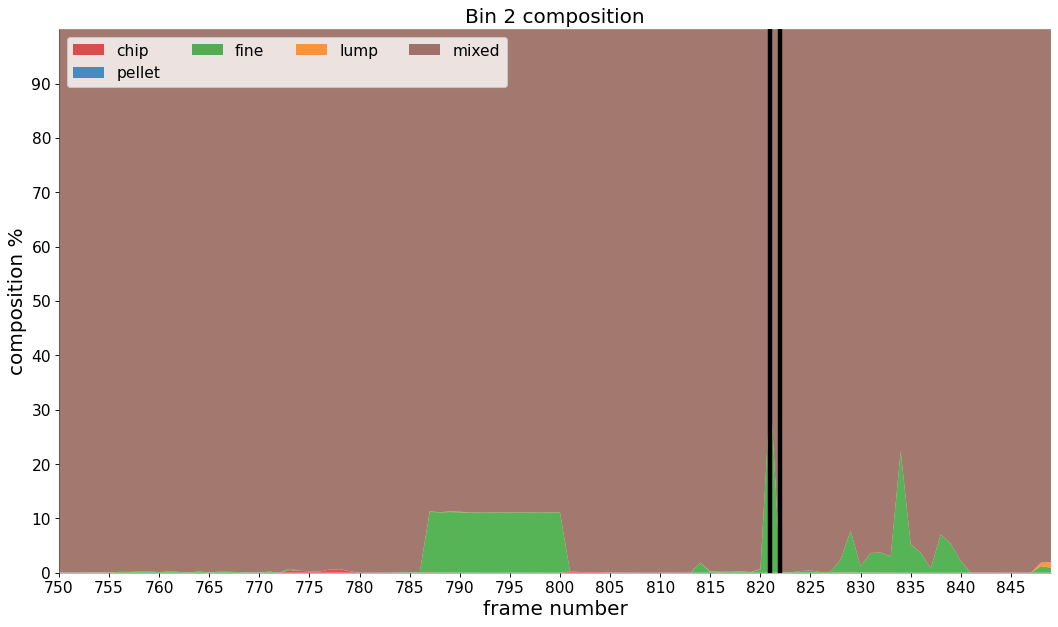

In [33]:
# Decide Colors 
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 'tab:grey', 'tab:pink', 'tab:olive']      

# Draw Plot and Annotate
fig, ax = plt.subplots(1,1,figsize=(16, 9), dpi= 80)
columns = df.columns[1:]
labs = columns.values.tolist()

# Prepare data
x  = df['frame'].values.tolist()
y0 = df[columns[0]].values.tolist()
y1 = df[columns[1]].values.tolist()
y2 = df[columns[2]].values.tolist()
y3 = df[columns[3]].values.tolist()
y4 = df[columns[4]].values.tolist()
y = np.vstack([y0, y1, y2, y3, y4])

# Plot for each column
labs = columns.values.tolist()
ax = plt.gca()
ax.stackplot(x, y, labels=labs, colors=mycolors, alpha=0.8)

# Decorations
ax.set_title('Bin 2 composition', fontsize=18)
ax.set(ylim=[0, 100])
ax.legend(fontsize=14, ncol=4)
plt.xticks(x[::5], fontsize=14, horizontalalignment='center')
plt.yticks(np.arange(0, 100, 10), fontsize=14)
plt.xlim(x[0], x[-1])
plt.xlabel('frame number', fontsize=18)
plt.ylabel('composition %', fontsize=18)

for i in not_frames:
  plt.axvline(x=i, linewidth=4, color='black')

# Lighten borders
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)

plt.show()

## Bin 4

In [ ]:
vid_path = "/content/drive/Shared drives/DSI Shared Folder/Module 2/Twist Data/bin_4.mp4"

cap = cv2.VideoCapture(vid_path)

N_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
has_img, img = cap.read()
if has_img:
  img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

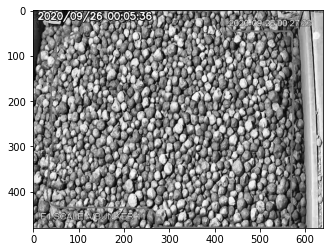

In [ ]:
plt.imshow(img_mono, cmap='gray')

In [34]:
vid_path = "/content/drive/Shared drives/DSI Shared Folder/Module 2/Twist Data/bin_4.mp4"

cap = cv2.VideoCapture(vid_path)

N_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

sample_window_size = 100
cnn_img_size = 100
all_predictions_graph = np.zeros((0,9))
predicted_probabilities_graph = np.zeros((0,5))
frames = np.zeros((0))
not_frames = np.zeros((0))

tic = time.process_time()

#First frame
has_img, img = cap.read() # Blue, Green, Red Numpy Array uint8

if has_img:
  # Images in your training set were monochrome
  img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  unique, counts = np.unique(img_mono, return_counts=True)
  dict_unique = dict(zip(unique, counts))
  if 0 in unique and (counts[0]/np.sum(counts) < 0.9):
    frames = np.append(frames, 0)
    # Grab a sample from the image. X=0, Y=0 is the top left corner. X and Y indicates the center of the sample.
    #x = 300
    #y = 200
    all_predictions = np.zeros((0))
    predicted_probabilities = np.zeros((5))

    for x in [200,300,400]:
      for y in [100,250,400]:
        sample, rect = sample_image(img_mono, int(x), int(y), sample_window_size, cnn_img_size)

        # TODO: CLASSIFER CODE HERE
        # The model gives us a matrix with each example's softmax probabilities for each class
        #print(predicted_probabilities)
        predicted_probabilities_new = model.predict(sample)
        #print("Sum predictions: ", np.sum(predicted_probabilities_new))
        predicted_probabilities = np.sum([predicted_probabilities, predicted_probabilities_new], axis=0)
        #print(predicted_probabilities)

        # We reduce that to a single predicted class for each example by taking the
        # class with the largest probability
        #prediction = np.argmax(predicted_probabilities, axis=1)
        
        #all_predictions = np.append(all_predictions, prediction)

    predicted_probabilities = predicted_probabilities/9
    #print(predicted_probabilities)
    #print("Sum probabilities for frame: ",np.sum(predicted_probabilities[0]))
    predicted_probabilities_graph = np.concatenate((predicted_probabilities_graph, predicted_probabilities),axis=0)
    #print(predicted_probabilities_graph)
    #occurence_count = Counter(all_predictions) 
    chip_per = predicted_probabilities[0][0]*100
    pell_per = predicted_probabilities[0][1]*100
    fine_per = predicted_probabilities[0][2]*100
    lump_per = predicted_probabilities[0][3]*100
    mix_per = predicted_probabilities[0][4]*100

    #print("Chip before: ", chip_per)
    #print("Pellets before: ", pell_per)
    #print("Fines before: ", fine_per)
    #print("Lump before: ", lump_per)
    #print("Mixed before: ", mix_per)
    #most_class_i = occurence_count.most_common(1)[0][0] 

    #clear_output(wait=True)      
    cv2_imshow(img_mono) 
    prediction = np.argmax(predicted_probabilities, axis=1)
    #print(prediction)
    #print(prediction[0])
    img_class = get_class(prediction[0])
    print(img_class)
  

#for frame_num in range(N_frames):
for frame_num in range(1, N_frames):

  has_img, img = cap.read() # Blue, Green, Red Numpy Array uint8

  if has_img and frame_num in range(220,320):
    
    # Images in your trainging set were monochrome
    img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    unique, counts = np.unique(img_mono, return_counts=True)
    dict_unique = dict(zip(unique, counts))
    if 0 in unique and (counts[0]/np.sum(counts) < 0.9):
      frames = np.append(frames, frame_num)
      # Grab a sample from the image. X=0, Y=0 is the top left corner. X and Y indicates the center of the sample.
      #x = 300
      #y = 200
      all_predictions = np.zeros((0))
      predicted_probabilities = np.zeros((5))

      for x in [200,300,400]:
        for y in [100,250,400]:
          sample, rect = sample_image(img_mono, int(x), int(y), sample_window_size, cnn_img_size)

          # TODO: CLASSIFER CODE HERE
          # The model gives us a matrix with each example's softmax probabilities for each class
          predicted_probabilities_new = model.predict(sample)

          #print("Sum predictions: ", np.sum(predicted_probabilities_new))

          predicted_probabilities = np.sum([predicted_probabilities, predicted_probabilities_new], axis=0)

          # We reduce that to a single predicted class for each example by taking the
          # class with the largest probability
          #prediction = np.argmax(predicted_probabilities, axis=1)
        
          #all_predictions = np.append(all_predictions, prediction)

      #occurence_count = Counter(all_predictions) 
      #most_class = occurence_count.most_common(1)[0][0] 

      # TODO: DECIDE IF NOFITICATION FRAME SHOUD BE SAVED

      predicted_probabilities = predicted_probabilities/9

      #print("Sum probabilities for frame: ",np.sum(predicted_probabilities[0]))

      chip_per_new = predicted_probabilities[0][0]*100
      pell_per_new = predicted_probabilities[0][1]*100
      fine_per_new = predicted_probabilities[0][2]*100
      lump_per_new = predicted_probabilities[0][3]*100
      mix_per_new = predicted_probabilities[0][4]*100

      if  ( ((abs(chip_per_new - chip_per) > 20 or abs(lump_per_new - lump_per) > 20) and (img_class != 'lump' and img_class != 'chip')) or abs(pell_per_new - pell_per) > 20 or abs(fine_per_new - fine_per) > 20 or (mix_per_new - mix_per) > 20):

        not_frames = np.append(not_frames, frame_num)
        #most_class_i = most_class
        #plt.imshow(sample[0], cmap='gray')

        #clear_output(wait=True)      
        prediction = np.argmax(predicted_probabilities, axis=1)
        cv2_imshow(img_mono) 
        img_class_temp = img_class
        img_class = get_class(prediction[0])

        if img_class == img_class_temp:
          img_class = 'change'
        print("Frame number: ", frame_num, " most common class: ", img_class)
        print("Chip before: ", chip_per, " and after: ", chip_per_new)
        print("Pellets before: ", pell_per, " and after: ", pell_per_new)
        print("Fines before: ", fine_per, " and after: ", fine_per_new)
        print("Lump before: ", lump_per, " and after: ", lump_per_new)
        print("Mixed before: ", mix_per, " and after: ", mix_per_new)



      # TODO: BUILD ARRAY FOR MATERIAL COMPOSITION GRAPH

      chip_per = chip_per_new
      pell_per = pell_per_new
      fine_per = fine_per_new
      lump_per = lump_per_new
      mix_per = mix_per_new
      predicted_probabilities_graph = np.concatenate((predicted_probabilities_graph, predicted_probabilities),axis=0)

      # COLAB
      # - - - - - - - - - - - - 
      #clear_output(wait=True)
      #cv2_imshow(sample[0]) 
      #plt.imshow(sample[0], cmap='gray')
      #print(img_class)
      #cv2.waitKey(1000) & 0xff
      # - - - - - - - - - - - - 

      # Local
      # - - - - - - - - - - - - 
      #cv2.imshow(img_mono)
      #cv2.waitKey(1000)
      # - - - - - - - - - - - -  

dt = time.process_time() - tic

print(dt/100)
#print(dt/N_frames) # Samples per frame should be below 150 ms


Output hidden; open in https://colab.research.google.com to view.

In [36]:
df = pd.DataFrame({'frame': [], 'chip': [], 'pellet':[], 'fine':[],'lump':[],'mixed':[]})
for i in range(1,100):
  row_df = pd.DataFrame({'frame': [frames[i]], 'chip': [predicted_probabilities_graph[i][0]*100], 'pellet':[predicted_probabilities_graph[i][1]*100], 'fine':[predicted_probabilities_graph[i][2]*100],'lump':[predicted_probabilities_graph[i][3]*100],'mixed':[predicted_probabilities_graph[i][4]*100]})
  df = pd.concat([df, row_df], ignore_index=True)

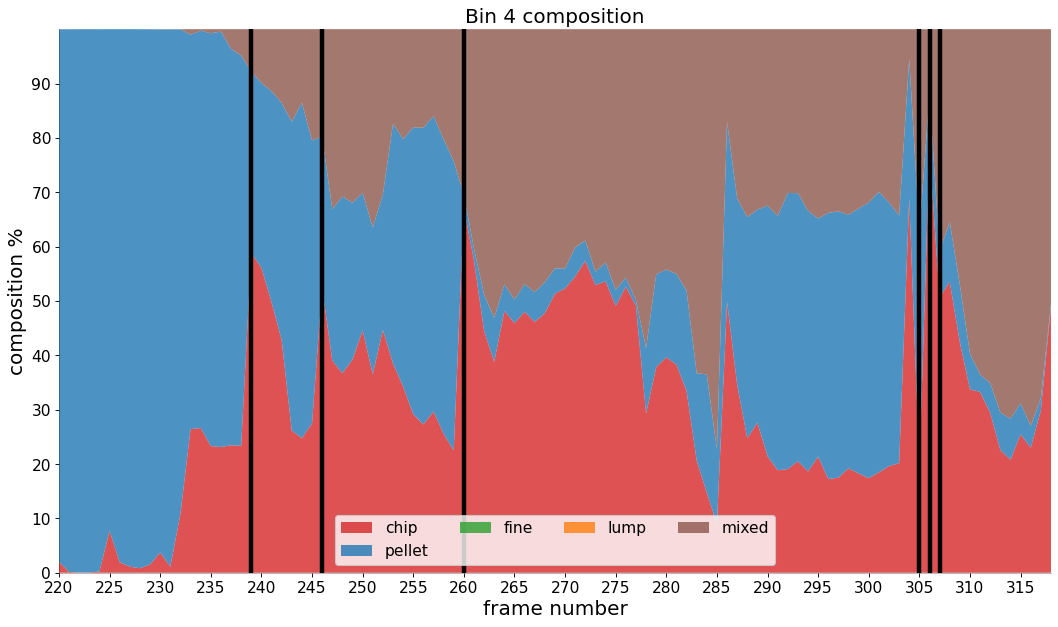

In [38]:
# Decide Colors 
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 'tab:grey', 'tab:pink', 'tab:olive']      

# Draw Plot and Annotate
fig, ax = plt.subplots(1,1,figsize=(16, 9), dpi= 80)
columns = df.columns[1:]
labs = columns.values.tolist()

# Prepare data
x  = df['frame'].values.tolist()
y0 = df[columns[0]].values.tolist()
y1 = df[columns[1]].values.tolist()
y2 = df[columns[2]].values.tolist()
y3 = df[columns[3]].values.tolist()
y4 = df[columns[4]].values.tolist()
y = np.vstack([y0, y1, y2, y3, y4])

# Plot for each column
labs = columns.values.tolist()
ax = plt.gca()
ax.stackplot(x, y, labels=labs, colors=mycolors, alpha=0.8)

# Decorations
ax.set_title('Bin 4 composition', fontsize=18)
ax.set(ylim=[0, 100])
ax.legend(fontsize=14, ncol=4)
plt.xticks(x[::5], fontsize=14, horizontalalignment='center')
plt.yticks(np.arange(0, 100, 10), fontsize=14)
plt.xlim(x[0], x[-1])
plt.xlabel('frame number', fontsize=18)
plt.ylabel('composition %', fontsize=18)

for i in not_frames:
  plt.axvline(x=i, linewidth=4, color='black')

# Lighten borders
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)

plt.show()

## Bin 5

In [ ]:
vid_path = "/content/drive/Shared drives/DSI Shared Folder/Module 2/Twist Data/bin_5.mp4"

cap = cv2.VideoCapture(vid_path)

N_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
has_img, img = cap.read()
if has_img:
  img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

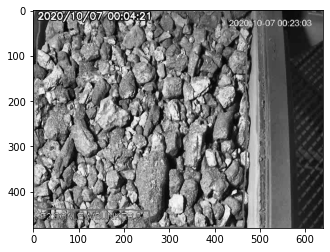

In [ ]:
plt.imshow(img_mono, cmap='gray')

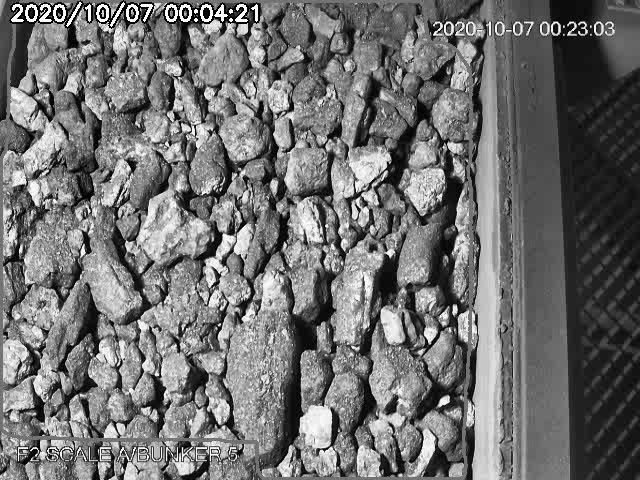

lump


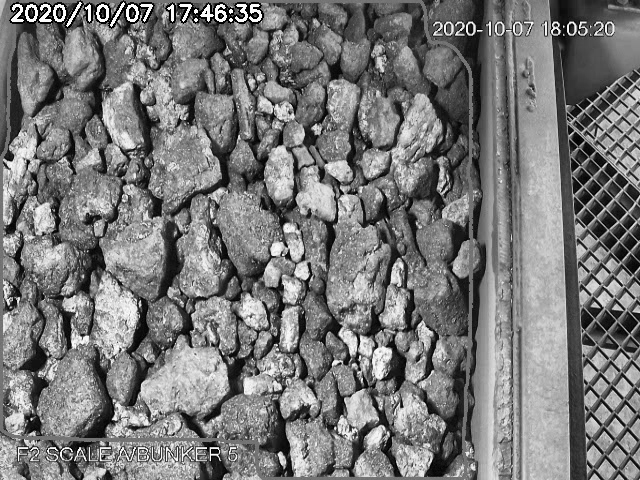

Frame number:  1081  most common class:  mixed
Chip before:  17.814809989920455  and after:  19.039479789085412
Pellets before:  0.0003282866717263059  and after:  6.3941155802203926e-06
Fines before:  0.00010654600837156636  and after:  0.0030573405987629108
Lump before:  45.631823502480984  and after:  23.30607064343187
Mixed before:  36.5529316632698  and after:  57.65138453183075


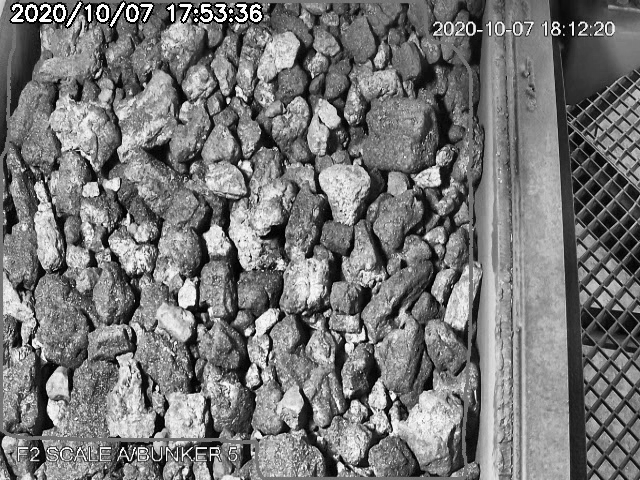

Frame number:  1088  most common class:  lump
Chip before:  14.162997612675099  and after:  25.632034565379257
Pellets before:  4.7944258119159144e-06  and after:  8.772874541671589e-06
Fines before:  0.002044554081336179  and after:  0.002146436206899978
Lump before:  16.427036591630895  and after:  59.12862716141439
Mixed before:  69.40791938039992  and after:  15.237185363134309


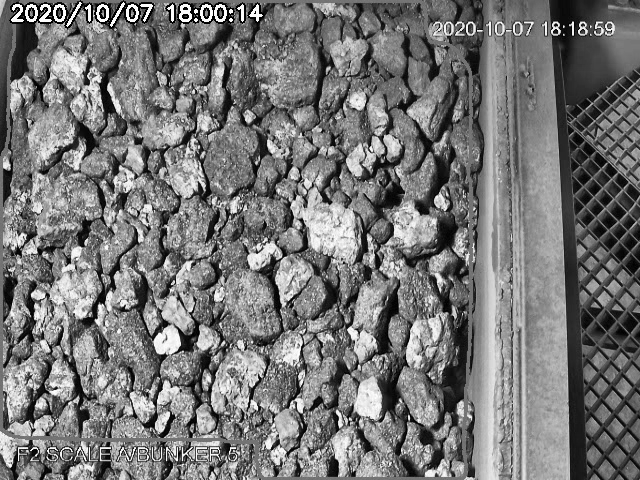

Frame number:  1095  most common class:  mixed
Chip before:  25.51052367760281  and after:  30.38165128107519
Pellets before:  9.525801871067428e-06  and after:  6.819859493492311e-06
Fines before:  0.0022934940597945127  and after:  0.00021480749892413244
Lump before:  59.089333057762715  and after:  12.646776539976498
Mixed before:  15.397840186455547  and after:  56.97135489899665


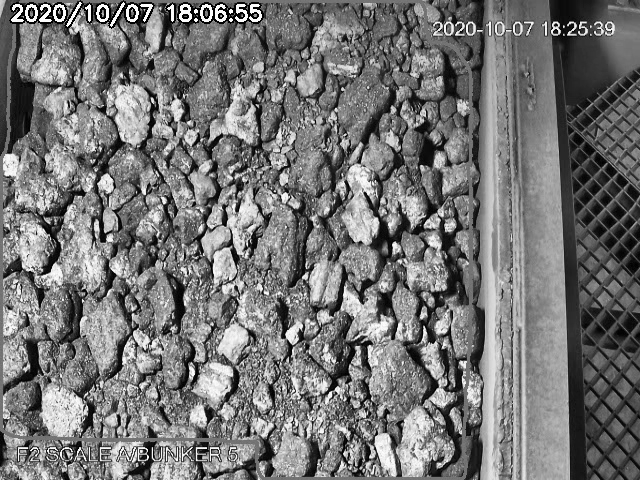

Frame number:  1102  most common class:  change
Chip before:  20.722466495984314  and after:  44.8456760482966
Pellets before:  8.42638651694156e-06  and after:  0.0001022595703744263
Fines before:  0.00023052347040018894  and after:  0.012636949020280237
Lump before:  12.822955822374146  and after:  0.32119158573446305
Mixed before:  66.45434010359976  and after:  54.82039094527459


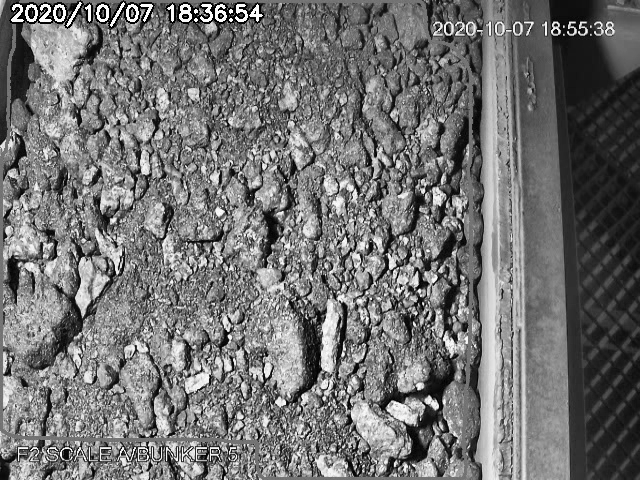

Frame number:  1134  most common class:  chip
Chip before:  37.95314509002815  and after:  36.85613561186376
Pellets before:  5.1689138401577063e-05  and after:  0.0002002432065890187
Fines before:  0.560845314888963  and after:  33.239030236220266
Lump before:  1.156231962860943  and after:  2.3898830059301366
Mixed before:  60.32972673419863  and after:  27.514746165575666
1.82620371042


In [48]:
vid_path = "/content/drive/Shared drives/DSI Shared Folder/Module 2/Twist Data/bin_5.mp4"

cap = cv2.VideoCapture(vid_path)

N_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

sample_window_size = 100
cnn_img_size = 100
all_predictions_graph = np.zeros((0,9))
predicted_probabilities_graph = np.zeros((0,5))
frames = np.zeros((0))
not_frames = np.zeros((0))

tic = time.process_time()

#First frame
has_img, img = cap.read() # Blue, Green, Red Numpy Array uint8

if has_img:
  # Images in your training set were monochrome
  img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  unique, counts = np.unique(img_mono, return_counts=True)
  dict_unique = dict(zip(unique, counts))
  if 0 in unique and (counts[0]/np.sum(counts) < 0.9):
    frames = np.append(frames, 0)
    # Grab a sample from the image. X=0, Y=0 is the top left corner. X and Y indicates the center of the sample.
    #x = 300
    #y = 200
    all_predictions = np.zeros((0))
    predicted_probabilities = np.zeros((5))

    for x in [200,300,400]:
      for y in [100,250,400]:
        sample, rect = sample_image(img_mono, int(x), int(y), sample_window_size, cnn_img_size)

        # TODO: CLASSIFER CODE HERE
        # The model gives us a matrix with each example's softmax probabilities for each class
        #print(predicted_probabilities)
        predicted_probabilities_new = model.predict(sample)
        #print("Sum predictions: ", np.sum(predicted_probabilities_new))
        predicted_probabilities = np.sum([predicted_probabilities, predicted_probabilities_new], axis=0)
        #print(predicted_probabilities)

        # We reduce that to a single predicted class for each example by taking the
        # class with the largest probability
        #prediction = np.argmax(predicted_probabilities, axis=1)
        
        #all_predictions = np.append(all_predictions, prediction)

    predicted_probabilities = predicted_probabilities/9
    #print(predicted_probabilities)
    #print("Sum probabilities for frame: ",np.sum(predicted_probabilities[0]))
    predicted_probabilities_graph = np.concatenate((predicted_probabilities_graph, predicted_probabilities),axis=0)
    #print(predicted_probabilities_graph)
    #occurence_count = Counter(all_predictions) 
    chip_per = predicted_probabilities[0][0]*100
    pell_per = predicted_probabilities[0][1]*100
    fine_per = predicted_probabilities[0][2]*100
    lump_per = predicted_probabilities[0][3]*100
    mix_per = predicted_probabilities[0][4]*100

    #print("Chip before: ", chip_per)
    #print("Pellets before: ", pell_per)
    #print("Fines before: ", fine_per)
    #print("Lump before: ", lump_per)
    #print("Mixed before: ", mix_per)
    #most_class_i = occurence_count.most_common(1)[0][0] 

    #clear_output(wait=True)      
    cv2_imshow(img_mono) 
    prediction = np.argmax(predicted_probabilities, axis=1)
    #print(prediction)
    #print(prediction[0])
    img_class = get_class(prediction[0])
    print(img_class)
  

#for frame_num in range(N_frames):
for frame_num in range(1, N_frames):

  has_img, img = cap.read() # Blue, Green, Red Numpy Array uint8

  if has_img and frame_num in range(1050,1150):
    
    # Images in your trainging set were monochrome
    img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    unique, counts = np.unique(img_mono, return_counts=True)
    dict_unique = dict(zip(unique, counts))
    if 0 in unique and (counts[0]/np.sum(counts) < 0.9):
      frames = np.append(frames, frame_num)
      # Grab a sample from the image. X=0, Y=0 is the top left corner. X and Y indicates the center of the sample.
      #x = 300
      #y = 200
      all_predictions = np.zeros((0))
      predicted_probabilities = np.zeros((5))

      for x in [200,300,400]:
        for y in [100,250,400]:
          sample, rect = sample_image(img_mono, int(x), int(y), sample_window_size, cnn_img_size)

          # TODO: CLASSIFER CODE HERE
          # The model gives us a matrix with each example's softmax probabilities for each class
          predicted_probabilities_new = model.predict(sample)

          #print("Sum predictions: ", np.sum(predicted_probabilities_new))

          predicted_probabilities = np.sum([predicted_probabilities, predicted_probabilities_new], axis=0)

          # We reduce that to a single predicted class for each example by taking the
          # class with the largest probability
          #prediction = np.argmax(predicted_probabilities, axis=1)
        
          #all_predictions = np.append(all_predictions, prediction)

      #occurence_count = Counter(all_predictions) 
      #most_class = occurence_count.most_common(1)[0][0] 

      # TODO: DECIDE IF NOFITICATION FRAME SHOUD BE SAVED

      predicted_probabilities = predicted_probabilities/9

      #print("Sum probabilities for frame: ",np.sum(predicted_probabilities[0]))

      chip_per_new = predicted_probabilities[0][0]*100
      pell_per_new = predicted_probabilities[0][1]*100
      fine_per_new = predicted_probabilities[0][2]*100
      lump_per_new = predicted_probabilities[0][3]*100
      mix_per_new = predicted_probabilities[0][4]*100

      if  ( ((abs(chip_per_new - chip_per) > 20 or abs(lump_per_new - lump_per) > 20) and (img_class != 'lump' and img_class != 'chip')) or abs(pell_per_new - pell_per) > 20 or abs(fine_per_new - fine_per) > 20 or (mix_per_new - mix_per) > 20):

        not_frames = np.append(not_frames, frame_num)
        #most_class_i = most_class
        #plt.imshow(sample[0], cmap='gray')

        #clear_output(wait=True)      
        prediction = np.argmax(predicted_probabilities, axis=1)
        cv2_imshow(img_mono) 
        img_class_temp = img_class
        img_class = get_class(prediction[0])

        if img_class == img_class_temp:
          img_class = 'change'
        print("Frame number: ", frame_num, " most common class: ", img_class)
        print("Chip before: ", chip_per, " and after: ", chip_per_new)
        print("Pellets before: ", pell_per, " and after: ", pell_per_new)
        print("Fines before: ", fine_per, " and after: ", fine_per_new)
        print("Lump before: ", lump_per, " and after: ", lump_per_new)
        print("Mixed before: ", mix_per, " and after: ", mix_per_new)



      # TODO: BUILD ARRAY FOR MATERIAL COMPOSITION GRAPH

      chip_per = chip_per_new
      pell_per = pell_per_new
      fine_per = fine_per_new
      lump_per = lump_per_new
      mix_per = mix_per_new
      predicted_probabilities_graph = np.concatenate((predicted_probabilities_graph, predicted_probabilities),axis=0)

      # COLAB
      # - - - - - - - - - - - - 
      #clear_output(wait=True)
      #cv2_imshow(sample[0]) 
      #plt.imshow(sample[0], cmap='gray')
      #print(img_class)
      #cv2.waitKey(1000) & 0xff
      # - - - - - - - - - - - - 

      # Local
      # - - - - - - - - - - - - 
      #cv2.imshow(img_mono)
      #cv2.waitKey(1000)
      # - - - - - - - - - - - -  

dt = time.process_time() - tic

print(dt/100)
#print(dt/N_frames) # Samples per frame should be below 150 ms


In [49]:
df = pd.DataFrame({'frame': [], 'chip': [], 'pellet':[], 'fine':[],'lump':[],'mixed':[]})
for i in range(1,100):
  row_df = pd.DataFrame({'frame': [frames[i]], 'chip': [predicted_probabilities_graph[i][0]*100], 'pellet':[predicted_probabilities_graph[i][1]*100], 'fine':[predicted_probabilities_graph[i][2]*100],'lump':[predicted_probabilities_graph[i][3]*100],'mixed':[predicted_probabilities_graph[i][4]*100]})
  df = pd.concat([df, row_df], ignore_index=True)

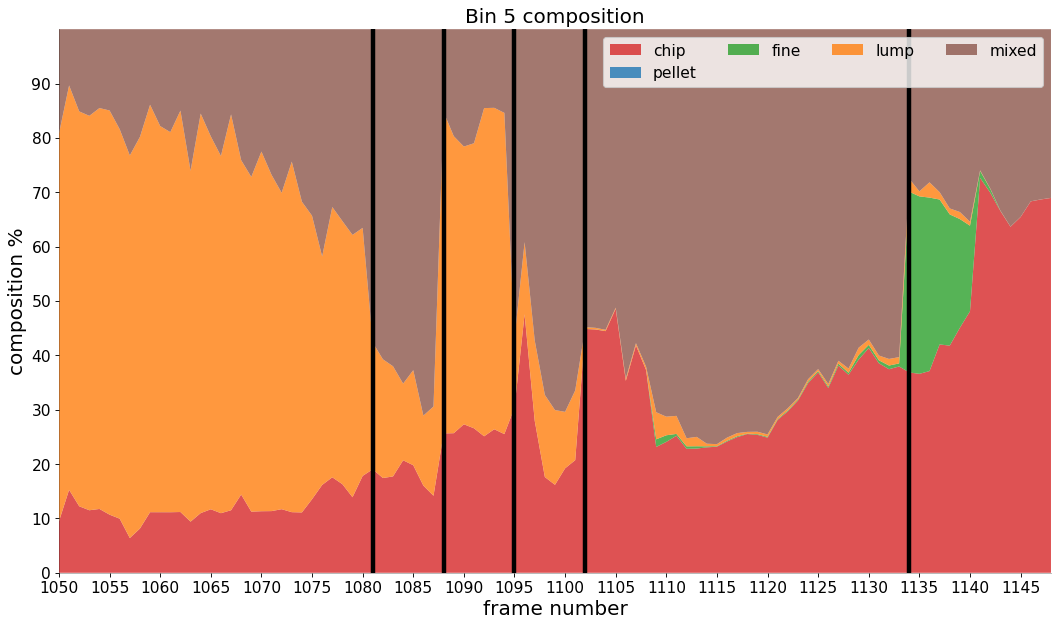

In [50]:
# Decide Colors 
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 'tab:grey', 'tab:pink', 'tab:olive']      

# Draw Plot and Annotate
fig, ax = plt.subplots(1,1,figsize=(16, 9), dpi= 80)
columns = df.columns[1:]
labs = columns.values.tolist()

# Prepare data
x  = df['frame'].values.tolist()
y0 = df[columns[0]].values.tolist()
y1 = df[columns[1]].values.tolist()
y2 = df[columns[2]].values.tolist()
y3 = df[columns[3]].values.tolist()
y4 = df[columns[4]].values.tolist()
y = np.vstack([y0, y1, y2, y3, y4])

# Plot for each column
labs = columns.values.tolist()
ax = plt.gca()
ax.stackplot(x, y, labels=labs, colors=mycolors, alpha=0.8)

# Decorations
ax.set_title('Bin 5 composition', fontsize=18)
ax.set(ylim=[0, 100])
ax.legend(fontsize=14, ncol=4)
plt.xticks(x[::5], fontsize=14, horizontalalignment='center')
plt.yticks(np.arange(0, 100, 10), fontsize=14)
plt.xlim(x[0], x[-1])
plt.xlabel('frame number', fontsize=18)
plt.ylabel('composition %', fontsize=18)

for i in not_frames:
  plt.axvline(x=i, linewidth=4, color='black')

# Lighten borders
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)

plt.show()

## Bin 6

In [ ]:
vid_path = "/content/drive/Shared drives/DSI Shared Folder/Module 2/Twist Data/bin_6.mp4"

cap = cv2.VideoCapture(vid_path)

N_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
has_img, img = cap.read()
if has_img:
  img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

unique, counts = np.unique(img_mono, return_counts=True)
dict_unique = dict(zip(unique, counts))

In [ ]:
unique, counts = np.unique(img_mono, return_counts=True)
dict_unique = dict(zip(unique, counts))
if 0 in unique:
  if (counts[0]/np.sum(counts) > 0.9):
    print("problem")

problem


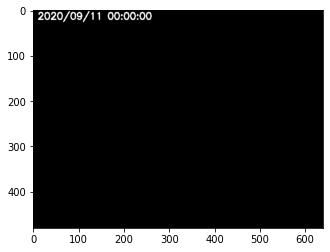

In [ ]:
plt.imshow(img_mono, cmap='gray')

In [43]:
vid_path = "/content/drive/Shared drives/DSI Shared Folder/Module 2/Twist Data/bin_6.mp4"

cap = cv2.VideoCapture(vid_path)

N_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

sample_window_size = 100
cnn_img_size = 100
all_predictions_graph = np.zeros((0,9))
predicted_probabilities_graph = np.zeros((0,5))
frames = np.zeros((0))
not_frames = np.zeros((0))

tic = time.process_time()

#First frame
has_img, img = cap.read() # Blue, Green, Red Numpy Array uint8

if has_img:
  # Images in your training set were monochrome
  img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  unique, counts = np.unique(img_mono, return_counts=True)
  dict_unique = dict(zip(unique, counts))
  if 0 in unique and (counts[0]/np.sum(counts) < 0.9):
    frames = np.append(frames, 0)
    # Grab a sample from the image. X=0, Y=0 is the top left corner. X and Y indicates the center of the sample.
    #x = 300
    #y = 200
    all_predictions = np.zeros((0))
    predicted_probabilities = np.zeros((5))

    for x in [200,300,400]:
      for y in [100,250,400]:
        sample, rect = sample_image(img_mono, int(x), int(y), sample_window_size, cnn_img_size)

        # TODO: CLASSIFER CODE HERE
        # The model gives us a matrix with each example's softmax probabilities for each class
        #print(predicted_probabilities)
        predicted_probabilities_new = model.predict(sample)
        #print("Sum predictions: ", np.sum(predicted_probabilities_new))
        predicted_probabilities = np.sum([predicted_probabilities, predicted_probabilities_new], axis=0)
        #print(predicted_probabilities)

        # We reduce that to a single predicted class for each example by taking the
        # class with the largest probability
        #prediction = np.argmax(predicted_probabilities, axis=1)
        
        #all_predictions = np.append(all_predictions, prediction)

    predicted_probabilities = predicted_probabilities/9
    #print(predicted_probabilities)
    #print("Sum probabilities for frame: ",np.sum(predicted_probabilities[0]))
    predicted_probabilities_graph = np.concatenate((predicted_probabilities_graph, predicted_probabilities),axis=0)
    #print(predicted_probabilities_graph)
    #occurence_count = Counter(all_predictions) 
    chip_per = predicted_probabilities[0][0]*100
    pell_per = predicted_probabilities[0][1]*100
    fine_per = predicted_probabilities[0][2]*100
    lump_per = predicted_probabilities[0][3]*100
    mix_per = predicted_probabilities[0][4]*100

    #print("Chip before: ", chip_per)
    #print("Pellets before: ", pell_per)
    #print("Fines before: ", fine_per)
    #print("Lump before: ", lump_per)
    #print("Mixed before: ", mix_per)
    #most_class_i = occurence_count.most_common(1)[0][0] 

    #clear_output(wait=True)      
    cv2_imshow(img_mono) 
    prediction = np.argmax(predicted_probabilities, axis=1)
    #print(prediction)
    #print(prediction[0])
    img_class = get_class(prediction[0])
    print(img_class)
  

#for frame_num in range(N_frames):
for frame_num in range(1, N_frames):

  has_img, img = cap.read() # Blue, Green, Red Numpy Array uint8

  if has_img and frame_num in range(60,160):
    
    # Images in your trainging set were monochrome
    img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    unique, counts = np.unique(img_mono, return_counts=True)
    dict_unique = dict(zip(unique, counts))
    if 0 in unique and (counts[0]/np.sum(counts) < 0.9):
      frames = np.append(frames, frame_num)
      # Grab a sample from the image. X=0, Y=0 is the top left corner. X and Y indicates the center of the sample.
      #x = 300
      #y = 200
      all_predictions = np.zeros((0))
      predicted_probabilities = np.zeros((5))

      for x in [200,300,400]:
        for y in [100,250,400]:
          sample, rect = sample_image(img_mono, int(x), int(y), sample_window_size, cnn_img_size)

          # TODO: CLASSIFER CODE HERE
          # The model gives us a matrix with each example's softmax probabilities for each class
          predicted_probabilities_new = model.predict(sample)

          #print("Sum predictions: ", np.sum(predicted_probabilities_new))

          predicted_probabilities = np.sum([predicted_probabilities, predicted_probabilities_new], axis=0)

          # We reduce that to a single predicted class for each example by taking the
          # class with the largest probability
          #prediction = np.argmax(predicted_probabilities, axis=1)
        
          #all_predictions = np.append(all_predictions, prediction)

      #occurence_count = Counter(all_predictions) 
      #most_class = occurence_count.most_common(1)[0][0] 

      # TODO: DECIDE IF NOFITICATION FRAME SHOUD BE SAVED

      predicted_probabilities = predicted_probabilities/9

      #print("Sum probabilities for frame: ",np.sum(predicted_probabilities[0]))

      chip_per_new = predicted_probabilities[0][0]*100
      pell_per_new = predicted_probabilities[0][1]*100
      fine_per_new = predicted_probabilities[0][2]*100
      lump_per_new = predicted_probabilities[0][3]*100
      mix_per_new = predicted_probabilities[0][4]*100

      if  ( ((abs(chip_per_new - chip_per) > 20 or abs(lump_per_new - lump_per) > 20) and (img_class != 'lump' and img_class != 'chip')) or abs(pell_per_new - pell_per) > 20 or abs(fine_per_new - fine_per) > 20 or (mix_per_new - mix_per) > 20):

        not_frames = np.append(not_frames, frame_num)
        #most_class_i = most_class
        #plt.imshow(sample[0], cmap='gray')

        #clear_output(wait=True)      
        prediction = np.argmax(predicted_probabilities, axis=1)
        cv2_imshow(img_mono) 
        img_class_temp = img_class
        img_class = get_class(prediction[0])

        if img_class == img_class_temp:
          img_class = 'change'
        print("Frame number: ", frame_num, " most common class: ", img_class)
        print("Chip before: ", chip_per, " and after: ", chip_per_new)
        print("Pellets before: ", pell_per, " and after: ", pell_per_new)
        print("Fines before: ", fine_per, " and after: ", fine_per_new)
        print("Lump before: ", lump_per, " and after: ", lump_per_new)
        print("Mixed before: ", mix_per, " and after: ", mix_per_new)



      # TODO: BUILD ARRAY FOR MATERIAL COMPOSITION GRAPH

      chip_per = chip_per_new
      pell_per = pell_per_new
      fine_per = fine_per_new
      lump_per = lump_per_new
      mix_per = mix_per_new
      predicted_probabilities_graph = np.concatenate((predicted_probabilities_graph, predicted_probabilities),axis=0)

      # COLAB
      # - - - - - - - - - - - - 
      #clear_output(wait=True)
      #cv2_imshow(sample[0]) 
      #plt.imshow(sample[0], cmap='gray')
      #print(img_class)
      #cv2.waitKey(1000) & 0xff
      # - - - - - - - - - - - - 

      # Local
      # - - - - - - - - - - - - 
      #cv2.imshow(img_mono)
      #cv2.waitKey(1000)
      # - - - - - - - - - - - -  

dt = time.process_time() - tic

print(dt/100)
#print(dt/N_frames) # Samples per frame should be below 150 ms


Output hidden; open in https://colab.research.google.com to view.

In [46]:
df = pd.DataFrame({'frame': [], 'chip': [], 'pellet':[], 'fine':[],'lump':[],'mixed':[]})
for i in range(0,100):
  row_df = pd.DataFrame({'frame': [frames[i]], 'chip': [predicted_probabilities_graph[i][0]*100], 'pellet':[predicted_probabilities_graph[i][1]*100], 'fine':[predicted_probabilities_graph[i][2]*100],'lump':[predicted_probabilities_graph[i][3]*100],'mixed':[predicted_probabilities_graph[i][4]*100]})
  df = pd.concat([df, row_df], ignore_index=True)

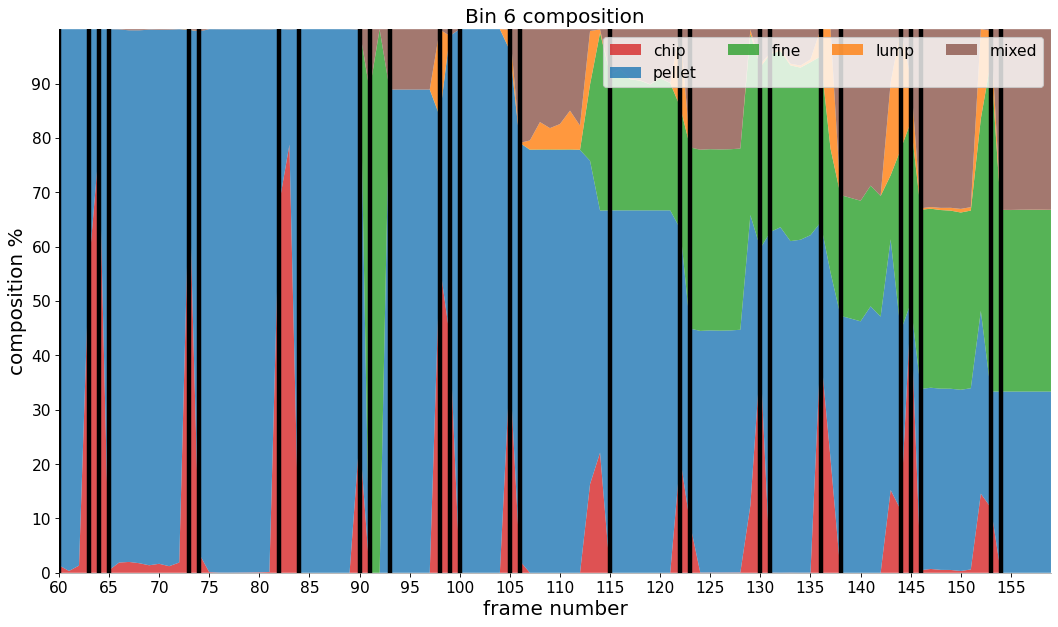

In [47]:
# Decide Colors 
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 'tab:grey', 'tab:pink', 'tab:olive']      

# Draw Plot and Annotate
fig, ax = plt.subplots(1,1,figsize=(16, 9), dpi= 80)
columns = df.columns[1:]
labs = columns.values.tolist()

# Prepare data
x  = df['frame'].values.tolist()
y0 = df[columns[0]].values.tolist()
y1 = df[columns[1]].values.tolist()
y2 = df[columns[2]].values.tolist()
y3 = df[columns[3]].values.tolist()
y4 = df[columns[4]].values.tolist()
y = np.vstack([y0, y1, y2, y3, y4])

# Plot for each column
labs = columns.values.tolist()
ax = plt.gca()
ax.stackplot(x, y, labels=labs, colors=mycolors, alpha=0.8)

# Decorations
ax.set_title('Bin 6 composition', fontsize=18)
ax.set(ylim=[0, 100])
ax.legend(fontsize=14, ncol=4)
plt.xticks(x[::5], fontsize=14, horizontalalignment='center')
plt.yticks(np.arange(0, 100, 10), fontsize=14)
plt.xlim(x[0], x[-1])
plt.xlabel('frame number', fontsize=18)
plt.ylabel('composition %', fontsize=18)

for i in not_frames:
  plt.axvline(x=i, linewidth=4, color='black')

# Lighten borders
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)

plt.show()

## Bin 7

In [ ]:
vid_path = "/content/drive/Shared drives/DSI Shared Folder/Module 2/Twist Data/bin_7.mp4"

cap = cv2.VideoCapture(vid_path)

N_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
has_img, img = cap.read()
if has_img:
  img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

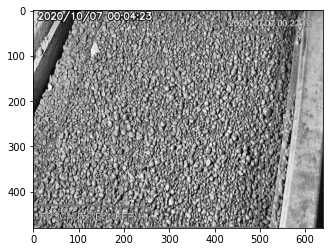

In [ ]:
plt.imshow(img_mono, cmap='gray')

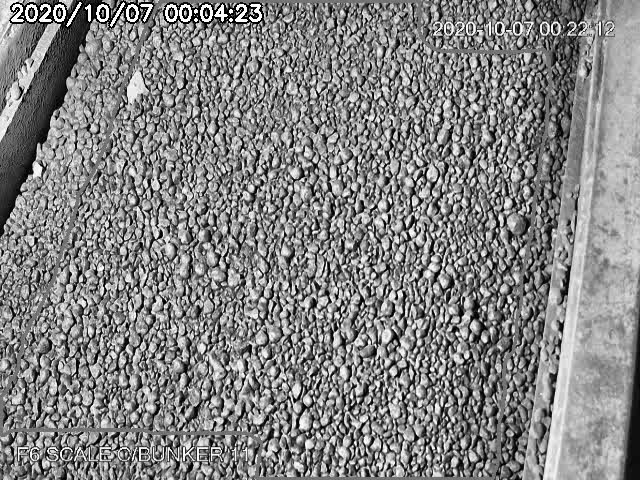

pellet


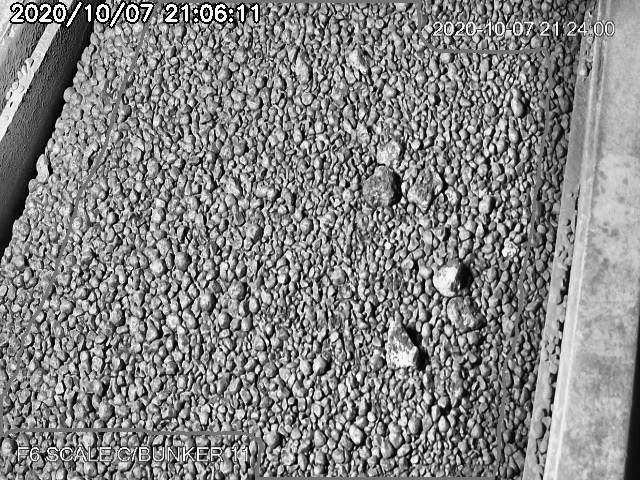

Frame number:  1313  most common class:  change
Chip before:  0.6246298267633232  and after:  6.081255281728422
Pellets before:  99.2049647702111  and after:  78.57557063301405
Fines before:  5.077635180204088e-06  and after:  0.017869031443357046
Lump before:  4.943292334405641e-06  and after:  0.0011523339597981996
Mixed before:  0.1703971302502537  and after:  15.324154395521106


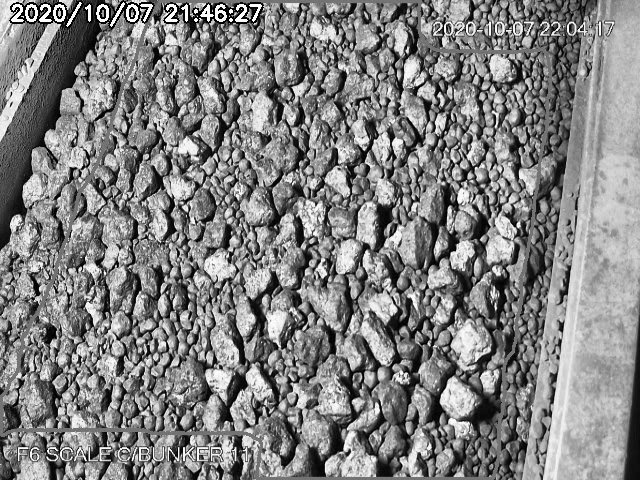

Frame number:  1353  most common class:  chip
Chip before:  12.529800801510444  and after:  73.96038735492361
Pellets before:  68.75770059443893  and after:  5.648467811999088e-05
Fines before:  4.613314802238822e-06  and after:  4.291204697576229e-05
Lump before:  5.276054403091646e-06  and after:  0.003192827145876493
Mixed before:  18.712487958257245  and after:  26.036320404253072
1.8314285750399995


In [51]:
vid_path = "/content/drive/Shared drives/DSI Shared Folder/Module 2/Twist Data/bin_7.mp4"

cap = cv2.VideoCapture(vid_path)

N_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

sample_window_size = 100
cnn_img_size = 100
all_predictions_graph = np.zeros((0,9))
predicted_probabilities_graph = np.zeros((0,5))
frames = np.zeros((0))
not_frames = np.zeros((0))

tic = time.process_time()

#First frame
has_img, img = cap.read() # Blue, Green, Red Numpy Array uint8

if has_img:
  # Images in your training set were monochrome
  img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  unique, counts = np.unique(img_mono, return_counts=True)
  dict_unique = dict(zip(unique, counts))
  if 0 in unique and (counts[0]/np.sum(counts) < 0.9):
    frames = np.append(frames, 0)
    # Grab a sample from the image. X=0, Y=0 is the top left corner. X and Y indicates the center of the sample.
    #x = 300
    #y = 200
    all_predictions = np.zeros((0))
    predicted_probabilities = np.zeros((5))

    for x in [200,300,400]:
      for y in [100,250,400]:
        sample, rect = sample_image(img_mono, int(x), int(y), sample_window_size, cnn_img_size)

        # TODO: CLASSIFER CODE HERE
        # The model gives us a matrix with each example's softmax probabilities for each class
        #print(predicted_probabilities)
        predicted_probabilities_new = model.predict(sample)
        #print("Sum predictions: ", np.sum(predicted_probabilities_new))
        predicted_probabilities = np.sum([predicted_probabilities, predicted_probabilities_new], axis=0)
        #print(predicted_probabilities)

        # We reduce that to a single predicted class for each example by taking the
        # class with the largest probability
        #prediction = np.argmax(predicted_probabilities, axis=1)
        
        #all_predictions = np.append(all_predictions, prediction)

    predicted_probabilities = predicted_probabilities/9
    #print(predicted_probabilities)
    #print("Sum probabilities for frame: ",np.sum(predicted_probabilities[0]))
    predicted_probabilities_graph = np.concatenate((predicted_probabilities_graph, predicted_probabilities),axis=0)
    #print(predicted_probabilities_graph)
    #occurence_count = Counter(all_predictions) 
    chip_per = predicted_probabilities[0][0]*100
    pell_per = predicted_probabilities[0][1]*100
    fine_per = predicted_probabilities[0][2]*100
    lump_per = predicted_probabilities[0][3]*100
    mix_per = predicted_probabilities[0][4]*100

    #print("Chip before: ", chip_per)
    #print("Pellets before: ", pell_per)
    #print("Fines before: ", fine_per)
    #print("Lump before: ", lump_per)
    #print("Mixed before: ", mix_per)
    #most_class_i = occurence_count.most_common(1)[0][0] 

    #clear_output(wait=True)      
    cv2_imshow(img_mono) 
    prediction = np.argmax(predicted_probabilities, axis=1)
    #print(prediction)
    #print(prediction[0])
    img_class = get_class(prediction[0])
    print(img_class)
  

#for frame_num in range(N_frames):
for frame_num in range(1, N_frames):

  has_img, img = cap.read() # Blue, Green, Red Numpy Array uint8

  if has_img and frame_num in range(1280,1380):
    
    # Images in your trainging set were monochrome
    img_mono = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    unique, counts = np.unique(img_mono, return_counts=True)
    dict_unique = dict(zip(unique, counts))
    if 0 in unique and (counts[0]/np.sum(counts) < 0.9):
      frames = np.append(frames, frame_num)
      # Grab a sample from the image. X=0, Y=0 is the top left corner. X and Y indicates the center of the sample.
      #x = 300
      #y = 200
      all_predictions = np.zeros((0))
      predicted_probabilities = np.zeros((5))

      for x in [200,300,400]:
        for y in [100,250,400]:
          sample, rect = sample_image(img_mono, int(x), int(y), sample_window_size, cnn_img_size)

          # TODO: CLASSIFER CODE HERE
          # The model gives us a matrix with each example's softmax probabilities for each class
          predicted_probabilities_new = model.predict(sample)

          #print("Sum predictions: ", np.sum(predicted_probabilities_new))

          predicted_probabilities = np.sum([predicted_probabilities, predicted_probabilities_new], axis=0)

          # We reduce that to a single predicted class for each example by taking the
          # class with the largest probability
          #prediction = np.argmax(predicted_probabilities, axis=1)
        
          #all_predictions = np.append(all_predictions, prediction)

      #occurence_count = Counter(all_predictions) 
      #most_class = occurence_count.most_common(1)[0][0] 

      # TODO: DECIDE IF NOFITICATION FRAME SHOUD BE SAVED

      predicted_probabilities = predicted_probabilities/9

      #print("Sum probabilities for frame: ",np.sum(predicted_probabilities[0]))

      chip_per_new = predicted_probabilities[0][0]*100
      pell_per_new = predicted_probabilities[0][1]*100
      fine_per_new = predicted_probabilities[0][2]*100
      lump_per_new = predicted_probabilities[0][3]*100
      mix_per_new = predicted_probabilities[0][4]*100

      if  ( ((abs(chip_per_new - chip_per) > 20 or abs(lump_per_new - lump_per) > 20) and (img_class != 'lump' and img_class != 'chip')) or abs(pell_per_new - pell_per) > 20 or abs(fine_per_new - fine_per) > 20 or (mix_per_new - mix_per) > 20):

        not_frames = np.append(not_frames, frame_num)
        #most_class_i = most_class
        #plt.imshow(sample[0], cmap='gray')

        #clear_output(wait=True)      
        prediction = np.argmax(predicted_probabilities, axis=1)
        cv2_imshow(img_mono) 
        img_class_temp = img_class
        img_class = get_class(prediction[0])

        if img_class == img_class_temp:
          img_class = 'change'
        print("Frame number: ", frame_num, " most common class: ", img_class)
        print("Chip before: ", chip_per, " and after: ", chip_per_new)
        print("Pellets before: ", pell_per, " and after: ", pell_per_new)
        print("Fines before: ", fine_per, " and after: ", fine_per_new)
        print("Lump before: ", lump_per, " and after: ", lump_per_new)
        print("Mixed before: ", mix_per, " and after: ", mix_per_new)



      # TODO: BUILD ARRAY FOR MATERIAL COMPOSITION GRAPH

      chip_per = chip_per_new
      pell_per = pell_per_new
      fine_per = fine_per_new
      lump_per = lump_per_new
      mix_per = mix_per_new
      predicted_probabilities_graph = np.concatenate((predicted_probabilities_graph, predicted_probabilities),axis=0)

      # COLAB
      # - - - - - - - - - - - - 
      #clear_output(wait=True)
      #cv2_imshow(sample[0]) 
      #plt.imshow(sample[0], cmap='gray')
      #print(img_class)
      #cv2.waitKey(1000) & 0xff
      # - - - - - - - - - - - - 

      # Local
      # - - - - - - - - - - - - 
      #cv2.imshow(img_mono)
      #cv2.waitKey(1000)
      # - - - - - - - - - - - -  

dt = time.process_time() - tic

print(dt/100)
#print(dt/N_frames) # Samples per frame should be below 150 ms


In [53]:
df = pd.DataFrame({'frame': [], 'chip': [], 'pellet':[], 'fine':[],'lump':[],'mixed':[]})
for i in range(1,100):
  row_df = pd.DataFrame({'frame': [frames[i]], 'chip': [predicted_probabilities_graph[i][0]*100], 'pellet':[predicted_probabilities_graph[i][1]*100], 'fine':[predicted_probabilities_graph[i][2]*100],'lump':[predicted_probabilities_graph[i][3]*100],'mixed':[predicted_probabilities_graph[i][4]*100]})
  df = pd.concat([df, row_df], ignore_index=True)

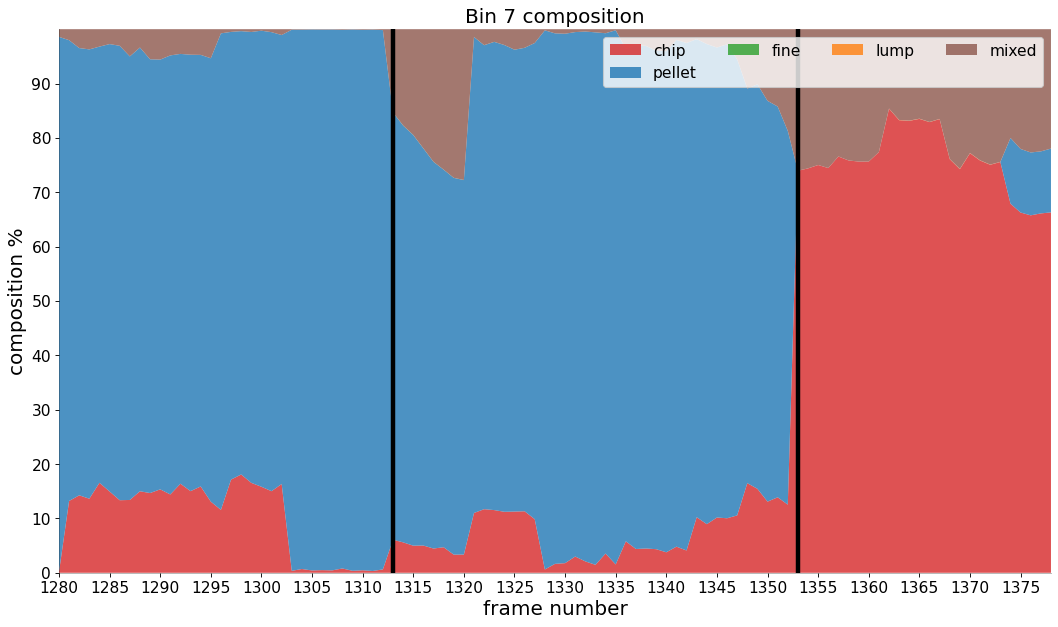

In [54]:
# Decide Colors 
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 'tab:grey', 'tab:pink', 'tab:olive']      

# Draw Plot and Annotate
fig, ax = plt.subplots(1,1,figsize=(16, 9), dpi= 80)
columns = df.columns[1:]
labs = columns.values.tolist()

# Prepare data
x  = df['frame'].values.tolist()
y0 = df[columns[0]].values.tolist()
y1 = df[columns[1]].values.tolist()
y2 = df[columns[2]].values.tolist()
y3 = df[columns[3]].values.tolist()
y4 = df[columns[4]].values.tolist()
y = np.vstack([y0, y1, y2, y3, y4])

# Plot for each column
labs = columns.values.tolist()
ax = plt.gca()
ax.stackplot(x, y, labels=labs, colors=mycolors, alpha=0.8)

# Decorations
ax.set_title('Bin 7 composition', fontsize=18)
ax.set(ylim=[0, 100])
ax.legend(fontsize=14, ncol=4)
plt.xticks(x[::5], fontsize=14, horizontalalignment='center')
plt.yticks(np.arange(0, 100, 10), fontsize=14)
plt.xlim(x[0], x[-1])
plt.xlabel('frame number', fontsize=18)
plt.ylabel('composition %', fontsize=18)

for i in not_frames:
  plt.axvline(x=i, linewidth=4, color='black')

# Lighten borders
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)

plt.show()